In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

from collections import Counter

import re
from langdetect import detect


from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

from itertools import chain

import json

In [2]:
hh_df = pd.read_excel('data/hh_all_IT_53052_vacancies_with_text_08062025.xlsx')

In [3]:
hh_other_df = pd.read_excel('data/hh_Drugie.xlsx')

In [4]:
# –ø—Ä–∏–≤–æ–¥–∏–º –∫ –æ–¥–Ω–æ–º—É —Å–ª–æ–≤–∞—Ä—é –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

column_mapping = {
    '–ù–∞–∑–≤–∞–Ω–∏–µ': 'vacancy',
    '–ö–æ–º–ø–∞–Ω–∏—è': 'company',
    '–ì–æ—Ä–æ–¥': 'city',
    '–û–ø—ã—Ç': 'experience',
    '–ó–∞–Ω—è—Ç–æ—Å—Ç—å': 'employment',
    '–ì—Ä–∞—Ñ–∏–∫': 'schedule',
    '–ó–∞—Ä–ø–ª–∞—Ç–∞ –æ—Ç': 'salary from',
    '–ó–∞—Ä–ø–ª–∞—Ç–∞ –¥–æ': 'salary to',
    '–í–∞–ª—é—Ç–∞': 'currency',
    '–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏': 'skills',
    'URL': 'url',
    '–î–∞—Ç–∞ –ø—É–±–ª–∏–∫–∞—Ü–∏–∏': 'date',
    #'–£—Ä–æ–≤–µ–Ω—å —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç–∞': 'level',
    #'—Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è': 'requirements',
    #'–æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏': 'responsibilities',
    'professional_role': 'position'
}

# –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º —Å—Ç–æ–ª–±—Ü—ã
hh_other_df = hh_other_df.rename(columns=column_mapping)

hh_other_df= hh_other_df.drop(['ID','–§–æ—Ä–º–∞—Ç —Ä–∞–±–æ—Ç—ã'], axis = 1)

In [5]:
superjob_df = pd.read_csv('data/superjob_2.csv')

In [6]:
superjob_df = superjob_df.drop('Unnamed: 0', axis = 1)

In [7]:
geekjobs_df = pd.read_csv('data/results_geekjob.csv')
theyseeku_df = pd.read_csv('data/results_finder.csv')

In [8]:
import re

def clean_text(text):
    # –ü—Ä–∏–≤–æ–¥–∏–º –∫ —Å—Ç—Ä–æ–∫–µ, —É–¥–∞–ª—è–µ–º –≤—Å–µ –ø—Ä–æ–±–µ–ª—ã –∏ –Ω–µ–≤–∏–¥–∏–º—ã–µ —Å–∏–º–≤–æ–ª—ã, –≤–∫–ª—é—á–∞—è –ø–µ—Ä–µ–Ω–æ—Å—ã —Å—Ç—Ä–æ–∫
    text = str(text)
    text = re.sub(r'\s+', '', text)  # –£–¥–∞–ª—è–µ–º –í–°–ï –ø—Ä–æ–±–µ–ª—ã, –ø–µ—Ä–µ–Ω–æ—Å—ã –∏ —Ç–∞–±—ã
    text = text.lower()              
    return text

# –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º –æ—á–∏—â–µ–Ω–Ω—ã–µ –≤–µ—Ä—Å–∏–∏ —Å—Ç–æ–ª–±—Ü–æ–≤
(geekjobs_df['text'].apply(clean_text) == geekjobs_df['skills'].apply(clean_text)).sum()

586

In [9]:
# –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º –æ—á–∏—â–µ–Ω–Ω—ã–µ –≤–µ—Ä—Å–∏–∏ —Å—Ç–æ–ª–±—Ü–æ–≤
(theyseeku_df['text'].apply(clean_text) == theyseeku_df['skills'].apply(clean_text)).sum()

0

In [10]:
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ  DataFrame –ø–æ —Å—Ç—Ä–æ–∫–∞–º
data = pd.concat([hh_other_df, hh_df, superjob_df, theyseeku_df], ignore_index=True, join='outer')

In [11]:
# –¥—É–±–ª–∏–∫–∞—Ç—ã
columns_to_check = [col for col in data.columns if col != 'date']
duplicates = data[data.duplicated(subset=columns_to_check, keep='first')]
print(f"–ù–∞–π–¥–µ–Ω–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {len(duplicates)}")

data = data.drop(duplicates.index, axis = 0 )

–ù–∞–π–¥–µ–Ω–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 5


In [12]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –∑–∞—Ä–ø–ª–∞—Ç


def clean_salary(salary):
    if pd.isna(salary) or salary == '' or salary == '–Ω–µ —É–∫–∞–∑–∞–Ω–∞':
        return np.nan
    
    # –ï—Å–ª–∏ —Å—Ç—Ä–æ–∫–∞, –æ—á–∏—â–∞–µ–º –æ—Ç –ª–∏—à–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤
    if isinstance(salary, str):
        # –£–¥–∞–ª—è–µ–º –ø—Ä–æ–±–µ–ª—ã –º–µ–∂–¥—É —Ü–∏—Ñ—Ä–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä '140 000' -> '140000')
        salary = salary.replace(' ', '')
        # –£–¥–∞–ª—è–µ–º –Ω–µ—á–∏—Å–ª–æ–≤—ã–µ —Å–∏–º–≤–æ–ª—ã (–∫—Ä–æ–º–µ —Ç–æ—á–∫–∏)
        salary = ''.join(c for c in salary if c.isdigit() or c == '.' or c == '-')
        # –û–±—Ä–∞–±–æ—Ç–∫–∞ –∑–Ω–∞—á–µ–Ω–∏–π —Ç–∏–ø–∞ '90k' (–ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ k –æ–∑–Ω–∞—á–∞–µ—Ç —Ç—ã—Å—è—á–∏)
        if 'k' in salary.lower():
            salary = salary.lower().replace('k', '')
            try:
                return float(salary) * 1000
            except:
                return np.nan
    
    try:
        return float(salary)
    except:
        return np.nan
        


In [13]:
cleaned_data = data.copy()

In [14]:
cleaned_data[cleaned_data['position'] == '–ì–µ–π–º-–¥–∏–∑–∞–π–Ω–µ—Ä']['skills']

84                            –ú–æ–Ω–µ—Ç–∏–∑–∞—Ü–∏—è –∏–≥—Ä, –ì–µ–π–º-–¥–∏–∑–∞–π–Ω
85       –ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫, Atlassian Jira, Atlassian Con...
86       –ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫, Atlassian Jira, Atlassian Con...
87                          Unreal Engine, 3C, Game Design
88                          Unreal Engine, Game Design, AI
                               ...                        
15308                                                  NaN
15309                                                  NaN
15310                                         Android, iOS
15311                                                  NaN
15312                                                  NaN
Name: skills, Length: 227, dtype: object

In [15]:
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –æ—á–∏—Å—Ç–∫–∏ –∫ —Å—Ç–æ–ª–±—Ü–∞–º —Å –∑–∞—Ä–ø–ª–∞—Ç–∞–º–∏
cleaned_data['salary from'] = cleaned_data['salary from'].apply(clean_salary)
cleaned_data['salary to'] = cleaned_data['salary to'].apply(clean_salary)

# –ø–æ–¥—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–Ω—á–µ–Ω–∏–π from / to  –æ—Ç —Å–æ—Å–µ–¥–∞

cleaned_data['salary from'] = cleaned_data['salary from'].fillna(cleaned_data['salary to'])
cleaned_data['salary to'] = cleaned_data['salary to'].fillna(cleaned_data['salary from'])

In [16]:
cleaned_data = cleaned_data.drop('employment.1', axis =1)

In [17]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59243 entries, 0 to 59247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          53703 non-null  object 
 1   date              54223 non-null  object 
 2   vacancy           59243 non-null  object 
 3   company           59243 non-null  object 
 4   city              59243 non-null  object 
 5   experience        51619 non-null  object 
 6   employment        58674 non-null  object 
 7   schedule          55355 non-null  object 
 8   salary from       24255 non-null  float64
 9   salary to         24255 non-null  float64
 10  currency          24255 non-null  object 
 11  skills            31930 non-null  object 
 12  url               59243 non-null  object 
 13  ID                53052 non-null  float64
 14  country           7591 non-null   object 
 15  industry          45461 non-null  object 
 16  text              58584 non-null  object 
 17

In [18]:
df =cleaned_data.copy()

#### –ò—Å—Å–ª–µ–¥—É–µ–º Skills –≤ —Ä–∞–∑—Ä–µ–∑–µ position

In [19]:
df['position'].value_counts()

position
–ü—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç, —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫                        12147
–°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏                 6154
–†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ø—Ä–æ–µ–∫—Ç–æ–≤                            4481
–î–∏–∑–∞–π–Ω–µ—Ä, —Ö—É–¥–æ–∂–Ω–∏–∫                               4006
–°–∏—Å—Ç–µ–º–Ω—ã–π –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ç–æ—Ä                          3856
–ê–Ω–∞–ª–∏—Ç–∏–∫                                         3722
–°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏        3001
–ú–µ–Ω–µ–¥–∂–µ—Ä –ø—Ä–æ–¥—É–∫—Ç–∞                                2156
–¢–µ—Å—Ç–∏—Ä–æ–≤—â–∏–∫                                      1900
–ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏—Ç–∏–∫                                  1588
–°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                               1470
BI-–∞–Ω–∞–ª–∏—Ç–∏–∫, –∞–Ω–∞–ª–∏—Ç–∏–∫ –¥–∞–Ω–Ω—ã—Ö                     1359
DevOps-–∏–Ω–∂–µ–Ω–µ—Ä                                   1234
–†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–ø–ø—ã —Ä–∞–∑—Ä

In [20]:
df['position'].value_counts().count()

25

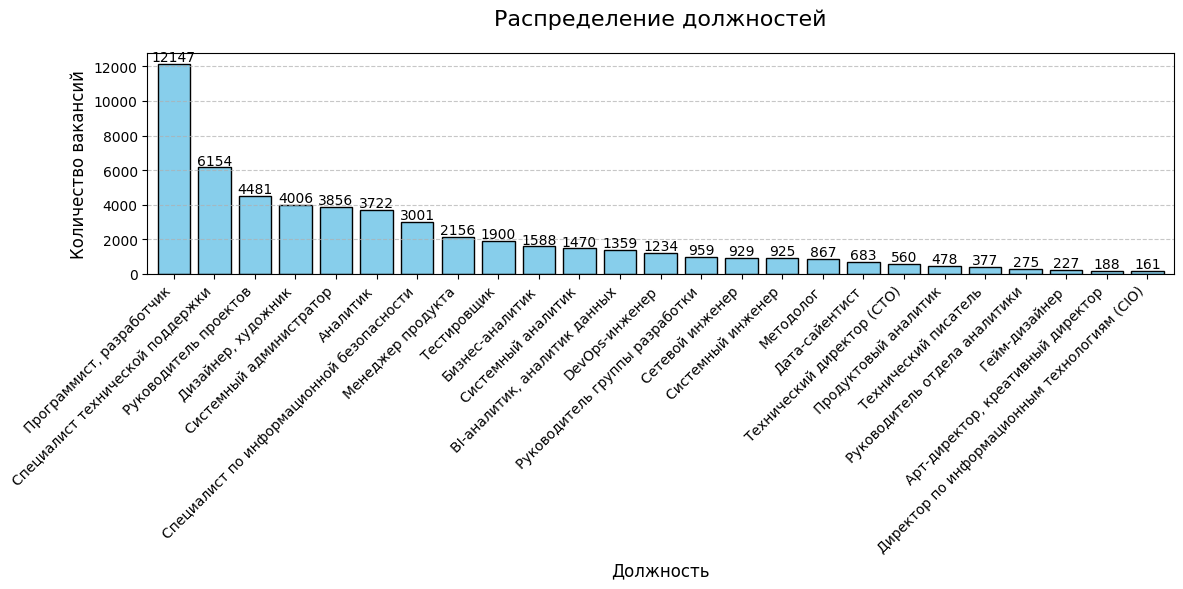

In [21]:
import matplotlib.pyplot as plt

# –ü–æ–ª—É—á–∞–µ–º —á–∞—Å—Ç–æ—Ç–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
position_counts = df['position'].value_counts()

# –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(12, 6))

# –ë–∞—Ä-—á–∞—Ä—Ç —Å –Ω–∞—Å—Ç—Ä–æ–π–∫–∞–º–∏
ax = position_counts.plot(kind='bar', 
                         color='skyblue',
                         edgecolor='black',
                         width=0.8)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ñ–æ—Ä–º–ª–µ–Ω–∏—è
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–æ–ª–∂–Ω–æ—Å—Ç–µ–π', fontsize=16, pad=20)
plt.xlabel('–î–æ–ª–∂–Ω–æ—Å—Ç—å', fontsize=12)
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–¥–ø–∏—Å–∏ –∑–Ω–∞—á–µ–Ω–∏–π
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

#### –ù–∞—á–∞–ª–æ —Ä–∞–±–æ—Ç—ã —Å–æ skills

In [22]:
df['skills']

0                                                      NaN
1        SQL, analyst, SDLC, Software Development, Paym...
2        –ò—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö, –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ...
3        Analysis, API, MS Excel, Power BI, Tableau, An...
4                                             SQL, Tableau
                               ...                        
59243                                                  NaN
59244                                                  NaN
59245                                                  NaN
59246                                                  NaN
59247                                                  NaN
Name: skills, Length: 59243, dtype: object

In [23]:
from ast import literal_eval

#–ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ skills –≤ —Å–ø–∏—Å–æ–∫
df['skills'] = df['skills'].apply(lambda x: [s.strip() for s in str(x).split(',')] if pd.notna(x) else [])

In [ ]:


positions = df['position'].value_counts().index

#–°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –∫–∞–∂–¥–æ–π –ø—Ä–æ—Ñ–µ—Å—Å–∏–∏
for position in positions:
    # –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ –ø—Ä–æ—Ñ–µ—Å—Å–∏–∏ –∏ —Å–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏
    skills_flat = [skill for sublist in df[df['position'] == position]['skills'] for skill in sublist]
    
    if not skills_flat:
        continue
        
    # –°—á–∏—Ç–∞–µ–º —á–∞—Å—Ç–æ—Ç—É –Ω–∞–≤—ã–∫–æ–≤
    skills_counts = pd.Series(skills_flat).value_counts().head(30)
    
    # –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
    plt.figure(figsize=(12, 6))
    skills_counts.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'–¢–æ–ø-30 –Ω–∞–≤—ã–∫–æ–≤ –¥–ª—è {position}\n(–í—Å–µ–≥–æ –≤–∞–∫–∞–Ω—Å–∏–π: {len(df[df["position"]==position])})')
    plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π')
    plt.tight_layout()
    plt.show()

In [24]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –ø—É—Å—Ç—ã—Ö —Å–ø–∏—Å–∫–æ–≤
def clean_skills(skill_data):
    if isinstance(skill_data, list):
        if len(skill_data) == 0:  # –ü—É—Å—Ç–æ–π —Å–ø–∏—Å–æ–∫ []
            return np.nan
        if len(skill_data) == 1 and isinstance(skill_data[0], list) and len(skill_data[0]) == 0:  # –°–ø–∏—Å–æ–∫ —Å –ø—É—Å—Ç—ã–º —Å–ø–∏—Å–∫–æ–º [[]]
            return np.nan
    return skill_data

# –ü—Ä–∏–º–µ–Ω—è–µ–º –æ—á–∏—Å—Ç–∫—É
df['skills_cleaned'] = df['skills'].apply(clean_skills)

In [ ]:


# –°–æ–∑–¥–∞–µ–º –ø—Ä–æ—Å—Ç—É—é —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É
stats = pd.DataFrame({
    '–ö–∞—Ç–µ–≥–æ—Ä–∏—è': ['–í—Å–µ–≥–æ –≤–∞–∫–∞–Ω—Å–∏–π', 
                 '–° skills (–Ω–µ –ø—É—Å—Ç—ã–µ)', 
                 '–ü—É—Å—Ç—ã–µ skills (–ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –≤ NaN)', 
                 '–ë–µ–∑ skills (–∏–∑–Ω–∞—á–∞–ª—å–Ω–æ NaN)'],
    '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ': [len(df),
                  df['skills_cleaned'].notna().sum(),
                  len(df) - df['skills_cleaned'].notna().sum() - df['skills'].isna().sum(),
                  df['skills'].isna().sum()]
})

print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏:")
print(stats)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
fig = px.bar(stats, 
             x='–ö–∞—Ç–µ–≥–æ—Ä–∏—è', 
             y='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ',
             title='–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ skills –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏',
             text='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ',
             color='–ö–∞—Ç–µ–≥–æ—Ä–∏—è')

fig.update_layout(showlegend=False)
fig.show()

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏:
                             –ö–∞—Ç–µ–≥–æ—Ä–∏—è  –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ
0                       –í—Å–µ–≥–æ –≤–∞–∫–∞–Ω—Å–∏–π       59243
1                 –° skills (–Ω–µ –ø—É—Å—Ç—ã–µ)       31930
2  –ü—É—Å—Ç—ã–µ skills (–ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –≤ NaN)       27313
3          –ë–µ–∑ skills (–∏–∑–Ω–∞—á–∞–ª—å–Ω–æ NaN)           0


c:\Users\–ê–Ω–¥—Ä–µ–π\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [26]:
# –ó–∞–º–µ–Ω—è–µ–º –∏—Å—Ö–æ–¥–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df['skills'] = df['skills_cleaned']
# –£–¥–∞–ª—è–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df.drop('skills_cleaned', axis=1, inplace=True)

In [ ]:


# 1. –°–æ–∑–¥–∞–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
stats = pd.DataFrame({
    '–ö–∞—Ç–µ–≥–æ—Ä–∏—è': ['–í—Å–µ–≥–æ –≤–∞–∫–∞–Ω—Å–∏–π', '–° position', '–ë–µ–∑ position', 
                 '–° skills', '–ë–µ–∑ skills', '–° salary from', '–ë–µ–∑ salary from'],
    '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ': [len(df), df['position'].notna().sum(), df['position'].isna().sum(),
                 df['skills'].notna().sum(), df['skills'].isna().sum(),
                 df['salary from'].notna().sum(), df['salary from'].isna().sum()]
})

combo_stats = pd.DataFrame({
    '–ö–∞—Ç–µ–≥–æ—Ä–∏—è': ['–° position –∏ skills', '–° position –Ω–æ –±–µ–∑ skills', 
                 '–ë–µ–∑ position –Ω–æ —Å skills', '–° position –∏ salary from', 
                 '–° position –Ω–æ –±–µ–∑ salary from', '–ë–µ–∑ position –∏ –±–µ–∑ salary from'],
    '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ': [df[df['position'].notna()]['skills'].notna().sum(),
                  df[df['position'].notna()]['skills'].isna().sum(),
                  df[df['position'].isna()]['skills'].notna().sum(),
                  df[df['position'].notna()]['salary from'].notna().sum(),
                  df[df['position'].notna()]['salary from'].isna().sum(),
                  df[df['position'].isna()]['salary from'].isna().sum()]
})

# 2. –°–æ–∑–¥–∞–µ–º –∏–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω—É—é –ø–∞–Ω–µ–ª—å
fig = make_subplots(rows=2, cols=2, 
                   subplot_titles=('–ó–∞–ø–æ–ª–Ω–µ–Ω–Ω–æ—Å—Ç—å –ø–æ–ª–µ–π (–∞–±—Å–æ–ª—é—Ç–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è)',
                                 '–ó–∞–ø–æ–ª–Ω–µ–Ω–Ω–æ—Å—Ç—å –ø–æ–ª–µ–π (% –æ—Ç –æ–±—â–µ–≥–æ —á–∏—Å–ª–∞)',
                                 '–ö–æ–º–±–∏–Ω–∞—Ü–∏–∏ –∑–∞–ø–æ–ª–Ω–µ–Ω–Ω—ã—Ö –ø–æ–ª–µ–π'))

# –ì—Ä–∞—Ñ–∏–∫ 1: –ê–±—Å–æ–ª—é—Ç–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
fig.add_trace(
    go.Bar(x=stats['–ö–∞—Ç–µ–≥–æ—Ä–∏—è'], y=stats['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ'], 
           marker_color='#636EFA'),
    row=1, col=1
)

# –ì—Ä–∞—Ñ–∏–∫ 2: –ü—Ä–æ—Ü–µ–Ω—Ç–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
fig.add_trace(
    go.Bar(x=stats['–ö–∞—Ç–µ–≥–æ—Ä–∏—è'], y=stats['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ']/len(df)*100,
           marker_color='#EF553B'),
    row=1, col=2
)

# –ì—Ä–∞—Ñ–∏–∫ 3: –ö–æ–º–±–∏–Ω–∞—Ü–∏–∏
fig.add_trace(
    go.Bar(x=combo_stats['–ö–∞—Ç–µ–≥–æ—Ä–∏—è'], y=combo_stats['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ'],
           marker_color='#00CC96'),
    row=2, col=1
)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≤–Ω–µ—à–Ω–µ–≥–æ –≤–∏–¥–∞
fig.update_layout(height=800, width=1000, 
                 title_text="–ê–Ω–∞–ª–∏–∑ –∑–∞–ø–æ–ª–Ω–µ–Ω–Ω–æ—Å—Ç–∏ –¥–∞–Ω–Ω—ã—Ö", showlegend=False)
fig.update_xaxes(tickangle=45)
fig.show()

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59243 entries, 0 to 59247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          53703 non-null  object 
 1   date              54223 non-null  object 
 2   vacancy           59243 non-null  object 
 3   company           59243 non-null  object 
 4   city              59243 non-null  object 
 5   experience        51619 non-null  object 
 6   employment        58674 non-null  object 
 7   schedule          55355 non-null  object 
 8   salary from       24255 non-null  float64
 9   salary to         24255 non-null  float64
 10  currency          24255 non-null  object 
 11  skills            31930 non-null  object 
 12  url               59243 non-null  object 
 13  ID                53052 non-null  float64
 14  country           7591 non-null   object 
 15  industry          45461 non-null  object 
 16  text              58584 non-null  object 
 17

In [27]:
df['vacancy'].nunique()

31286

In [ ]:


# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ df['skills'] —Å–æ–¥–µ—Ä–∂–∏—Ç —Å–ø–∏—Å–∫–∏ (–∏–ª–∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏—Ö)

df['skills_count'] = df['skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# –°—á–∏—Ç–∞–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π']

# –°—Ç—Ä–æ–∏–º –∏–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫
fig = px.bar(
    skills_dist,
    x='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    y='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    title='–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏—è—Ö',
    labels={'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤': '–ß–∏—Å–ª–æ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏–∏', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π': '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π'},
    text='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    color='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    color_continuous_scale='Viridis'
)

# –î–æ–±–∞–≤–ª—è–µ–º —Å—Ä–µ–¥–Ω—é—é –ª–∏–Ω–∏—é
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    text=f"–°—Ä–µ–¥–Ω–µ–µ: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [ ]:
df[df['skills_count'] == 0][['position', 'vacancy','skills', 'url']]

In [ ]:


# 1. –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ skills –≤ –ø–ª–æ—Å–∫–∏–π —Å–ø–∏—Å–æ–∫ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ –≤ –æ–¥–∏–Ω —Å–ø–∏—Å–æ–∫
all_skills = flatten_skills(df['skills'])

# 3. –ü–æ–¥—Å—á–µ—Ç —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
unique_skills_count = len(set(all_skills))  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
skills_frequency = Counter(all_skills)      # –ß–∞—Å—Ç–æ—Ç–∞ –∫–∞–∂–¥–æ–≥–æ –Ω–∞–≤—ã–∫–∞

print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: {unique_skills_count}")

# 4. –¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ'])
top_skills = top_skills.sort_values('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', ascending=False).head(50)

print("\n–¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:")
print(top_skills)

–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: 15512

–¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:
                                         –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ
SQL                                            4161
Linux                                          3352
Python                                         2952
PostgreSQL                                     2190
Git                                            2014
–ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫                                1559
1–° –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ                            1538
–¢–µ—Ö–Ω–∏—á–µ—Å–∫–∞—è –ø–æ–¥–¥–µ—Ä–∂–∫–∞                          1476
Docker                                         1417
JavaScript                                     1354
–ê–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–µ –º—ã—à–ª–µ–Ω–∏–µ                         1307
–†–∞–±–æ—Ç–∞ –≤ –∫–æ–º–∞–Ω–¥–µ                               1301
Adobe Photoshop                                1294
1–°: –ü—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ 8             

In [51]:
len(all_skills)

206801

#### –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –Ω–∞–≤—ã–∫–æ–≤ (skills)

In [165]:
import ast
import re
import numpy as np

def normalize_skills(raw):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return []

    # –ü–æ–ø—ã—Ç–∫–∞ –ø—Ä–∏–≤–µ—Å—Ç–∏ —Å—Ç—Ä–æ–∫—É, –ø–æ—Ö–æ–∂—É—é –Ω–∞ —Å–ø–∏—Å–æ–∫, –∫ –Ω–∞—Å—Ç–æ—è—â–µ–º—É —Å–ø–∏—Å–∫—É
    if isinstance(raw, str) and raw.strip().startswith('['):
        try:
            raw = ast.literal_eval(raw)
        except (SyntaxError, ValueError):
            raw = re.split(r",\s*", raw.strip("[]"))

    if isinstance(raw, np.ndarray):
        raw = raw.tolist()

    if isinstance(raw, str):
        raw = [raw]

    # –†–∞—Å–∫—Ä—ã—Ç–∏–µ –≤–ª–æ–∂–µ–Ω–Ω—ã—Ö —Å–ø–∏—Å–∫–æ–≤
    flattened = []
    for item in raw:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)

    # –û—á–∏—Å—Ç–∫–∞ –∫–∞–∂–¥–æ–≥–æ —Å–∫–∏–ª–ª–∞
    cleaned = []
    for skill in flattened:
        skill = str(skill).strip()

        # üí• –£–¥–∞–ª—è–µ–º –ª—é–±—ã–µ –∫–∞–≤—ã—á–∫–∏ –∏–ª–∏ —Å–∫–æ–±–∫–∏ –ø–æ –∫—Ä–∞—è–º
        skill = re.sub(r"^[\[\]\"']+|[\[\]\"']+$", "", skill).strip()

        if skill:
            cleaned.append(skill) #.lower()

    return cleaned

In [187]:
df['skills_clean'] = df['skills'].apply(normalize_skills)

In [188]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15058

In [189]:
def clean_skill(skill):
    # –£–¥–∞–ª—è–µ–º –æ–¥–∏–Ω–æ—á–Ω—ã–µ/–Ω–µ–∑–∞–∫—Ä—ã—Ç—ã–µ —Å–∫–æ–±–∫–∏ –∏ –ø—Ä–æ–±–µ–ª—ã
    skill = re.sub(r'\(\s*', '', skill)  # —É–¥–∞–ª—è–µ–º '(' –±–µ–∑ –ø–∞—Ä—ã
    skill = re.sub(r'\s*\)', '', skill)  # —É–¥–∞–ª—è–µ–º ')' –±–µ–∑ –ø–∞—Ä—ã
    #skill = re.sub(r'\[\s*', '', skill)  # —É–¥–∞–ª—è–µ–º '['
    #skill = re.sub(r'\s*\]', '', skill)  # —É–¥–∞–ª—è–µ–º ']'
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]


In [190]:
df['skills_clean'] = df['skills_clean'].apply(clean_skills_list)

In [208]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15032

In [ ]:

with open('data/response_1750781459792.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)
# –ó–∞–≥—Ä—É–∑–∫–∞ JSON –≤ DataFrame
df_cloveri = pd.json_normalize(
    json_data,
    meta=[
        "id", "created_date", "modified_date", "project_id", 
        "account_id", "user_id", "object_type", "object_item",
        "object_code", "name"
    ],
    meta_prefix="",  # –Ω–µ –¥–æ–±–∞–≤–ª—è—Ç—å –ø—Ä–µ—Ñ–∏–∫—Å –∫ –æ—Å–Ω–æ–≤–Ω—ã–º –ø–æ–ª—è–º
    sep="."  # —Ä–∞–∑–¥–µ–ª–∏—Ç–µ–ª—å –¥–ª—è –≤–ª–æ–∂–µ–Ω–Ω—ã—Ö –ø–æ–ª–µ–π
)

# –ó–∞–º–µ–Ω–∞ null –Ω–∞ None (–¥–ª—è –ø—Ä–∞–≤–∏–ª—å–Ω–æ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≤ pandas)
df_cloveri = df_cloveri.where(pd.notnull(df_cloveri), None)

# –ü—Ä–æ—Å–º–æ—Ç—Ä —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
display(df_cloveri.head())

id                      created_date  \
0  30e7fd62-9d57-4e41-b1ea-ac5dff528365  2025-06-24T17:51:58.090620+03:00   
1  c9247231-6bd3-43ce-8d0b-2e9a1435128f  2025-06-24T17:51:58.032283+03:00   
2  cdd11685-4ff4-45f0-be5d-1464e09fdbf4  2025-06-24T17:51:57.975724+03:00   
3  da845f36-ca3a-4bb6-994a-112bf96d4884  2025-06-24T17:51:57.891996+03:00   
4  e4e7d129-00c9-47e9-b181-044ac7f6a20f  2025-06-24T17:51:57.829734+03:00   

                      modified_date                            project_id  \
0  2025-06-24T17:51:58.090644+03:00  cb33d04f-fc33-4288-a124-3c8732680c86   
1  2025-06-24T17:51:58.032302+03:00  cb33d04f-fc33-4288-a124-3c8732680c86   
2  2025-06-24T17:51:57.975747+03:00  cb33d04f-fc33-4288-a124-3c8732680c86   
3  2025-06-24T17:51:57.892026+03:00  cb33d04f-fc33-4288-a124-3c8732680c86   
4  2025-06-24T17:51:57.829763+03:00  cb33d04f-fc33-4288-a124-3c8732680c86   

  account_id user_id object_type object_item  \
0       None    None       skill        None   
1       None    None       skill        None   
2       None    None       skill        None   
3       None    None       skill        None   
4       None    None       skill        None   

                                object_code  name  meta.flags meta.status  \
0  0949f7f067da85899c8ba315cc83d6fedb05dfd3  None           0      active   
1  0653e6cd172426e81eb5f9707cfe0b5622a04148  None           0      active   
2  35e734256b2d7f74101204268b5b9ae142717658  None           0      active   
3  7feb75d80f161e27b69bde7e08b566f2ed4a2327  None           0      active   
4  c9b47df7e36468a00acc8741fcba824e9f4c049a  None           0      active   

   meta.internal_id                                         data.title  \
0              3493       –í—ã–±–æ—Ä —Å–æ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–µ—Ç–µ–π –¥–ª—è –ø—Ä–æ–¥–≤–∏–∂–µ–Ω–∏—è –Ω–∞ –¶–ê   
1              3492                     –û—Ç—á–µ—Ç –æ —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞—Ö   
2              3491                 –í–µ–¥–µ–Ω–∏–µ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤–æ–π –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏–∏   
3              3490                     –û–ø—Ä–æ–≤–µ—Ä–∂–µ–Ω–∏–µ –∫–∞–∫ –≤–∏–¥ —É–±–µ–∂–¥–µ–Ω–∏—è   
4              3489  –°—Å—ã–ª–∫–∞ –Ω–∞ –æ–ø—ã—Ç —Å–æ–±–µ—Å–µ–¥–Ω–∏–∫–∞ –∫–∞–∫ –≤–∏–¥ –≤–ª–∏—è–Ω–∏—è –Ω–∞ ...   

   data.competence  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [37]:
display(df_cloveri['data.title'].describe())
display(df_cloveri['data.title'].value_counts())

count                                             3372
unique                                            3372
top       –í—ã–±–æ—Ä —Å–æ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–µ—Ç–µ–π –¥–ª—è –ø—Ä–æ–¥–≤–∏–∂–µ–Ω–∏—è –Ω–∞ –¶–ê
freq                                                 1
Name: data.title, dtype: object

data.title
–í—ã–±–æ—Ä —Å–æ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–µ—Ç–µ–π –¥–ª—è –ø—Ä–æ–¥–≤–∏–∂–µ–Ω–∏—è –Ω–∞ –¶–ê    1
RIPS Technologies                               1
OWASP Code Crawler                              1
Watchtower                                      1
OCLint                                          1
                                               ..
–°–æ–≤–º–µ—Å—Ç–Ω–∞—è —Ä–∞–±–æ—Ç–∞ (UX/UI)                       1
Material Colors Native                          1
Wrike                                           1
Adobe Color                                     1
–ë–∏–±–ª–∏–æ—Ç–µ–∫–∞ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è PyTest                  1
Name: count, Length: 3372, dtype: int64

In [38]:
cloveri_skill_list = df_cloveri['data.title'].unique().tolist()
jobsense = list(set(all_skills))

cloveri_skill_list_norm = cloveri_skill_list #[skill.lower() for skill in cloveri_skill_list]
count = 0
general_list = []
for skill in jobsense:
    if skill in cloveri_skill_list_norm:
        count +=1
        general_list.append(skill)
        
display(f'–í—Å–µ–≥–æ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π:  {count}' )

'–í—Å–µ–≥–æ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π:  419'

In [40]:
for item in cloveri_skill_list_norm:
    if '–†–∞–±–æ—Ç–∞ c' in item: 
        print(item)

–†–∞–±–æ—Ç–∞ c Instagram
–†–∞–±–æ—Ç–∞ c Microsoft Teams
–†–∞–±–æ—Ç–∞ c Zoom


In [41]:
display(general_list)

['Bugzilla',
 'SMTP',
 '–ö–∞–¥—Ä–æ–≤—ã–π —Ä–µ–∑–µ—Ä–≤',
 'Adobe InDesign',
 'WebRTC',
 '–ê–≤—Ç–æ–º–∞—Ç–∏–∑–∞—Ü–∏—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è',
 'JBoss',
 '–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏',
 'Kibana',
 '–•—Ä–∞–Ω–µ–Ω–∏–µ –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö',
 '–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–æ–Ω–Ω–æ–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ',
 '–ü–ª–∞—Ç–µ–∂–Ω—ã–µ —Å–∏—Å—Ç–µ–º—ã',
 'SaltStack',
 '–°–æ–∑–¥–∞–Ω–∏–µ –≤–∏—Ç—Ä–∏–Ω –¥–∞–Ω–Ω—ã—Ö',
 'Puppet',
 '–ù–∞–ª–æ–≥–æ–≤—ã–π —É—á—ë—Ç',
 'Wi-Fi',
 'SVN',
 '–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ',
 'AngularJS',
 '–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö',
 'Jest',
 '–§—É–Ω–∫—Ü–∏–æ–Ω–∞–ª—å–Ω–æ–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ',
 'Eclipse Vert.x',
 '–†–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω—ã–µ —Å–∏—Å—Ç–µ–º—ã',
 '–ö–æ–º–ø–æ–∑–∏—Ü–∏—è',
 'Zabbix',
 '–ú–µ—Ç–æ–¥—ã –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è',
 '–ü—Ä–æ–¥—É–∫—Ç–æ–≤–∞—è –∞–Ω–∞–ª–∏—Ç–∏–∫–∞',
 '–Æ–Ω–∏—Ç-—ç–∫–æ–Ω–æ–º–∏–∫–∞',
 '–£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –∫–æ–Ω—Ñ–ª–∏–∫—Ç–∞–º–∏',
 'Mercurial',
 'Apache Maven',
 '–ò–Ω—Ç–µ–≥—Ä–∞—Ü–∏–æ–Ω–Ω–æ–µ

In [ ]:


all_skills = list(chain.from_iterable(df['skills_clean']))
print("–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏:", len(set(all_skills)))

–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏: 15032


#### –°–ª–æ–≤–µ—Ä–∏ - –∫–∞–Ω–æ–Ω—ã , Jobsense - —Å–∏–Ω–æ–Ω–∏–º—ã + –æ—Å—Ç–∞—Ç–æ–∫ –≤  —Ä–µ–µ—Å—Ç—Ä –Ω–∞–≤—ã–∫–æ–≤ –∫–∞–∫ –Ω–æ–≤—ã–µ 
 

In [ ]:


# 1. –£–ª—É—á—à–µ–Ω–Ω–æ–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —è–∑—ã–∫–∞ —Å –≤—ã–¥–µ–ª–µ–Ω–∏–µ–º —Å–º–µ—à–∞–Ω–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
def detect_skill_lang(skill):
    try:
        words = re.findall(r'[a-z–∞-—è—ë0-9]+', skill.lower())
        if not words:
            return 'en'
        
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º –Ω–∞–ª–∏—á–∏–µ –∫–∏—Ä–∏–ª–ª–∏—Ü—ã –∏ –ª–∞—Ç–∏–Ω–∏—Ü—ã
        has_cyrillic = any(re.search(r'[–∞-—è—ë]', word) for word in words)
        has_latin = any(re.search(r'[a-z]', word) for word in words)
        
        if has_cyrillic and has_latin:
            return 'ru_en'  # –°–º–µ—à–∞–Ω–Ω—ã–π —Ç–∏–ø
        elif has_cyrillic:
            return 'ru'
        else:
            return 'en'
    except:
        return 'en'

# 2. –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ —Ç—Ä–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏
def split_skills(skill_list):
    ru, en, ru_en = [], [], []
    for skill in skill_list:
        lang = detect_skill_lang(skill)
        if lang == 'ru':
            ru.append(skill)
        elif lang == 'ru_en':
            ru_en.append(skill)
        else:
            en.append(skill)
    return ru, en, ru_en

# –†–∞–∑–¥–µ–ª—è–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ
cloveri_ru, cloveri_en, cloveri_ru_en = split_skills(cloveri_skill_list_norm)
jobsense_ru, jobsense_en, jobsense_ru_en = split_skills(jobsense)

In [353]:
print (len(cloveri_ru), len(cloveri_en), len(cloveri_ru_en), len(jobsense_ru), len(jobsense_en), len(jobsense_ru_en) )

2090 792 490 7199 5665 974


##### –õ–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è —Å —Ä–∞–∑–¥–µ–ª—å–Ω—ã–º–∏ –æ–±—Ä–∞–±–æ—Ç—á–∏–∫–∞–º–∏

In [ ]:


morph_ru = MorphAnalyzer()
lemmatizer_en = WordNetLemmatizer()

def lemmatize_skill(skill, lang):
    if lang == 'ru':
        words = re.findall(r'[–∞-—è—ë0-9]+', skill.lower())
        return ' '.join([morph_ru.parse(word)[0].normal_form for word in words])
    elif lang == 'ru_en':
        # –î–ª—è —Å–º–µ—à–∞–Ω–Ω—ã—Ö: –ª–µ–º–º–∞—Ç–∏–∑–∏—Ä—É–µ–º —Ç–æ–ª—å–∫–æ —Ä—É—Å—Å–∫–∏–µ —á–∞—Å—Ç–∏
        parts = []
        for word in re.findall(r'[–∞-—è—ëa-z0-9]+', skill.lower()):
            if re.search(r'[–∞-—è—ë]', word):
                parts.append(morph_ru.parse(word)[0].normal_form)
            else:
                parts.append(word)
        return ' '.join(parts)
    else:  # en
        words = re.findall(r'[a-z0-9]+', skill.lower())
        return ' '.join([lemmatizer_en.lemmatize(word) for word in words])

# –ü—Ä–∏–º–µ–Ω—è–µ–º –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—é
cloveri_ru_lemmas = [lemmatize_skill(s, 'ru') for s in cloveri_ru]
cloveri_en_lemmas = [lemmatize_skill(s, 'en') for s in cloveri_en]
cloveri_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in cloveri_ru_en]

jobsense_ru_lemmas = [lemmatize_skill(s, 'ru') for s in jobsense_ru]
jobsense_en_lemmas = [lemmatize_skill(s, 'en') for s in jobsense_en]
jobsense_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in jobsense_ru_en]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\–ê–Ω–¥—Ä–µ–π\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [355]:
print (len(cloveri_ru_lemmas), len(cloveri_en_lemmas), len(cloveri_ru_en_lemmas), len(jobsense_ru_lemmas), len(jobsense_en_lemmas), len(jobsense_ru_en_lemmas))

2090 792 490 7199 5665 974


In [ ]:
# –ö–∞–Ω–æ–Ω—ã (Cloveri) –∏ "–¥–∏–∫–∏–µ" –Ω–∞–≤—ã–∫–∏ (Jobsense)
canonical_ru = set(cloveri_ru_lemmas)
wild_skills_ru = set(jobsense_ru_lemmas) - canonical_ru

canonical_en = set(cloveri_en_lemmas)
wild_skills_en = set(jobsense_en_lemmas) - canonical_en

canonical_ru_en = set(cloveri_ru_en_lemmas)
wild_skills_ru_en = set(jobsense_ru_en_lemmas) - canonical_ru_en

In [340]:
print (len(canonical_ru), len(canonical_en), len(wild_skills_ru), len(wild_skills_en))

1679 996 4685 5406


##### –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è "–¥–∏–∫–∏—Ö" –Ω–∞–≤—ã–∫–æ–≤ –≤–æ–∫—Ä—É–≥ –∫–∞–Ω–æ–Ω–æ–≤

In [ ]:
import fasttext
import fasttext.util

# –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —è–∑—ã–∫–∞
ft_ru = fasttext.load_model('cc.ru.300.bin')
ft_en = fasttext.load_model('cc.en.300.bin')


In [356]:
def get_embedding(text, lang_type):
    if lang_type == 'ru':
        model = ft_ru
    elif lang_type == 'en':
        model = ft_en
    elif lang_type == 'ru_en':
        # –î–ª—è —Å–º–µ—à–∞–Ω–Ω—ã—Ö –∏—Å–ø–æ–ª—å–∑—É–µ–º –æ–±–µ –º–æ–¥–µ–ª–∏
        return get_mixed_embedding(text)
    else:
        return np.zeros(300)
    
    if model is None:
        return np.zeros(300)
    
    words = [w for w in text.split() if w]
    if not words:
        return np.zeros(300)
    
    embeddings = [model.get_word_vector(w) for w in words]
    return np.mean(embeddings, axis=0)

def get_mixed_embedding(text):
    """–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å–º–µ—à–∞–Ω–Ω—ã—Ö —Ä—É—Å—Å–∫–æ-–∞–Ω–≥–ª–∏–π—Å–∫–∏—Ö –Ω–∞–≤—ã–∫–æ–≤"""
    ru_embs, en_embs = [], []
    
    for word in text.split():
        if not word:
            continue
            
        # –û–ø—Ä–µ–¥–µ–ª—è–µ–º —è–∑—ã–∫ —Å–ª–æ–≤–∞
        has_cyrillic = bool(re.search(r'[–∞-—è—ë]', word.lower()))
        has_latin = bool(re.search(r'[a-z]', word.lower()))
        
        if has_cyrillic and ft_ru:
            ru_embs.append(ft_ru.get_word_vector(word))
        elif has_latin and ft_en:
            en_embs.append(ft_en.get_word_vector(word))
    
    # –í–∑–≤–µ—à–µ–Ω–Ω–æ–µ —Å—Ä–µ–¥–Ω–µ–µ (60% —Ä—É—Å—Å–∫–æ–≥–æ, 40% –∞–Ω–≥–ª–∏–π—Å–∫–æ–≥–æ)
    if ru_embs and en_embs:
        ru_mean = np.mean(ru_embs, axis=0)
        en_mean = np.mean(en_embs, axis=0)
        return 0.6 * ru_mean + 0.4 * en_mean
    elif ru_embs:
        return np.mean(ru_embs, axis=0)
    elif en_embs:
        return np.mean(en_embs, axis=0)
    return np.zeros(300)

In [ ]:


def process_all_skills():
    results = {}
    
    # –î–ª—è –∫–∞–∂–¥–æ–≥–æ —Ç–∏–ø–∞ –Ω–∞–≤—ã–∫–æ–≤
    for lang_type, canon_lemmas, wild_lemmas in [
        ('ru', cloveri_ru_lemmas, jobsense_ru_lemmas),
        ('en', cloveri_en_lemmas, jobsense_en_lemmas),
        ('ru_en', cloveri_ru_en_lemmas, jobsense_ru_en_lemmas)
    ]:
        # 1. –°–æ–ø–æ—Å—Ç–∞–≤–ª—è–µ–º —Å –∫–∞–Ω–æ–Ω–∞–º–∏
        matched = cluster_around_canons(
            wild_skills=wild_lemmas,
            canon_skills=canon_lemmas,
            lang_type=lang_type,
            threshold=0.6
        )
        
        # 2. –ù–∞—Ö–æ–¥–∏–º –Ω–µ—Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ –Ω–∞–≤—ã–∫–∏
        matched_skills = set().union(*matched.values())
        unmatched_skills = [s for s in wild_lemmas if s not in matched_skills]
        
        # 3. –ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º –Ω–µ—Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ
        new_clusters = cluster_skills(unmatched_skills, lang_type)
        
        # 4. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
        results[lang_type] = {
            'matched_to_canons': matched,
            'new_clusters': new_clusters
        }
    
    return results

def cluster_around_canons(wild_skills, canon_skills, lang_type, threshold=0.65):
    
    
    if not canon_skills or not wild_skills:
        return defaultdict(list)
    
    # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ —Å —É—á–µ—Ç–æ–º —è–∑—ã–∫–æ–≤–æ–≥–æ —Ç–∏–ø–∞
    canon_embs = np.array([get_embedding(skill, lang_type) for skill in canon_skills])
    wild_embs = np.array([get_embedding(skill, lang_type) for skill in wild_skills])
    
    # –ò—â–µ–º –±–ª–∏–∂–∞–π—à–∏–π –∫–∞–Ω–æ–Ω
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(canon_embs)
    distances, indices = nbrs.kneighbors(wild_embs)
    
    # –ì—Ä—É–ø–ø–∏—Ä—É–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
    clusters = defaultdict(list)
    for wild_skill, dist, idx in zip(wild_skills, distances, indices):
        if dist[0] <= (1 - threshold):
            canon_skill = canon_skills[idx[0]]
            clusters[canon_skill].append(wild_skill)
    
    return clusters

def cluster_skills(skills, lang_type, eps=0.5, min_samples=2):
    """–ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –Ω–µ—Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤"""
    if not skills:
        return {}
    
    embeddings = np.array([get_embedding(skill, lang_type) for skill in skills])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(embeddings)
    
    clusters = defaultdict(list)
    for skill, label in zip(skills, labels):
        if label != -1:
            clusters[f"new_cluster_{label}"].append(skill)
    
    return clusters

# –ó–∞–ø—É—Å–∫ –æ–±—Ä–∞–±–æ—Ç–∫–∏
final_results = process_all_skills()

# –ü—Ä–∏–º–µ—Ä –¥–æ—Å—Ç—É–ø–∞ –∫ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º:
print("Russian matched:", len(final_results['ru']['matched_to_canons']))

print("English matched:", len(final_results['en']['matched_to_canons']))

print("RU-EN matched:", len(final_results['ru_en']['matched_to_canons']))

print("Russian new clusters:", len(final_results['ru']['new_clusters']))

print("English new clusters:", len(final_results['en']['new_clusters']))

print("RU-EN new clusters::", len(final_results['ru_en']['new_clusters']))

Russian matched: 1154
English matched: 439
RU-EN matched: 111
Russian new clusters: 58
English new clusters: 137
RU-EN new clusters:: 32


In [367]:
def save_to_excel_with_original_skills(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Å–ø–∏—Å–∫–∏
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            # 1. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Å –∫–∞–Ω–æ–Ω–∞–º–∏ (—Å –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–º–∏ —Ñ–æ—Ä–º–∞–º–∏)
            matched_data = []
            for canon_lemma, synonym_lemmas in data['matched_to_canons'].items():
                # –ù–∞—Ö–æ–¥–∏–º –≤—Å–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã –∫–∞–Ω–æ–Ω–∞
                canon_original_forms = list(set(
                    orig for orig, lem in zip(canon_originals, canon_lemmas) 
                    if lem == canon_lemma
                ))
                
                # –ù–∞—Ö–æ–¥–∏–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã —Å–∏–Ω–æ–Ω–∏–º–æ–≤
                for syn_lemma in synonym_lemmas:
                    syn_original_forms = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == syn_lemma
                    ))
                    
                    # –°–æ–∑–¥–∞–µ–º –≤—Å–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –∫–∞–Ω–æ–Ω-—Å–∏–Ω–æ–Ω–∏–º
                    for canon_orig in canon_original_forms:
                        for syn_orig in syn_original_forms:
                            matched_data.append({
                                'language': lang_type,
                                'canon_original': canon_orig,
                                'synonym_original': syn_orig,
                                #'canon_lemma': canon_lemma,
                                #'synonym_lemma': syn_lemma
                            })
            
            if matched_data:
                pd.DataFrame(matched_data).to_excel(
                    writer, 
                    sheet_name=f"{lang_type}_matched", 
                    index=False
                )
            
            # 2. –°–æ—Ö—Ä–∞–Ω—è–µ–º –Ω–æ–≤—ã–µ –∫–ª–∞—Å—Ç–µ—Ä—ã (—Å –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–º–∏ —Ñ–æ—Ä–º–∞–º–∏)
            cluster_data = []
            for cluster_id, skill_lemmas in data['new_clusters'].items():
                # –ù–∞—Ö–æ–¥–∏–º –≤—Å–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –Ω–∞–≤—ã–∫–∞ –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ
                for skill_lemma in skill_lemmas:
                    skill_originals = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == skill_lemma
                    ))
                    
                    for skill_orig in skill_originals:
                        cluster_data.append({
                            'language': lang_type,
                            'cluster_id': cluster_id,
                            'skill_original': skill_orig,
                            #'skill_lemma': skill_lemma,
                            'proposed_canon': skill_originals[0]  # –ü–µ—Ä–≤—ã–π –Ω–∞–≤—ã–∫ –∫–∞–∫ –ø—Ä–µ–¥–ª–∞–≥–∞–µ–º—ã–π –∫–∞–Ω–æ–Ω
                        })
            
            if cluster_data:
                pd.DataFrame(cluster_data).to_excel(
                    writer,
                    sheet_name=f"{lang_type}_clusters",
                    index=False
                )

# –í—ã–∑—ã–≤–∞–µ–º —Ñ—É–Ω–∫—Ü–∏—é —Å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã—Ö —Ñ–æ—Ä–º
save_to_excel_with_original_skills(final_results, "data/final_skills_mapping_with_originals.xlsx")

In [368]:
def save_to_excel_with_original_skills_no_new_cluster(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Å–ø–∏—Å–∫–∏
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            # 1. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Å –∫–∞–Ω–æ–Ω–∞–º–∏ (—Å –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–º–∏ —Ñ–æ—Ä–º–∞–º–∏)
            matched_data = []
            for canon_lemma, synonym_lemmas in data['matched_to_canons'].items():
                # –ù–∞—Ö–æ–¥–∏–º –≤—Å–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã –∫–∞–Ω–æ–Ω–∞
                canon_original_forms = list(set(
                    orig for orig, lem in zip(canon_originals, canon_lemmas) 
                    if lem == canon_lemma
                ))
                
                # –ù–∞—Ö–æ–¥–∏–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã —Å–∏–Ω–æ–Ω–∏–º–æ–≤
                for syn_lemma in synonym_lemmas:
                    syn_original_forms = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == syn_lemma
                    ))
                    
                    # –°–æ–∑–¥–∞–µ–º –≤—Å–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –∫–∞–Ω–æ–Ω-—Å–∏–Ω–æ–Ω–∏–º
                    for canon_orig in canon_original_forms:
                        for syn_orig in syn_original_forms:
                            matched_data.append({
                                'language': lang_type,
                                'canon_original': canon_orig,
                                'synonym_original': syn_orig,
                                #'canon_lemma': canon_lemma,
                                #'synonym_lemma': syn_lemma
                            })
            
            if matched_data:
                pd.DataFrame(matched_data).to_excel(
                    writer, 
                    sheet_name=f"{lang_type}_matched", 
                    index=False
                )

# –í—ã–∑—ã–≤–∞–µ–º —Ñ—É–Ω–∫—Ü–∏—é —Å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã—Ö —Ñ–æ—Ä–º
save_to_excel_with_original_skills_no_new_cluster(final_results, "data/final_skills_mapping_with_originals_no_new_cluster.xlsx")

In [ ]:
# –ò—Å—Ö–æ–¥–Ω—ã–µ —Å–ø–∏—Å–∫–∏ —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º
cloveri_skill_list  # canon_original, —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º
jobsense = list(set(all_skills))  #all_skills       # synonym_original, —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º

# –°–æ–∑–¥–∞–µ–º –º–∞–ø–ø–∏–Ω–≥–∏ lower_case ‚Üí original_case
canon_case_map = {s.lower(): s for s in cloveri_skill_list}
synonym_case_map = {s.lower(): s for s in all_skills}

# –ó–∞–≥—Ä—É–∂–∞–µ–º Excel-—Ñ–∞–π–ª —Å –º–∞–ø–ø–∏–Ω–≥–∞–º–∏
input_file = "data/final_skills_mapping_with_originals_no_new_cluster.xlsx"
output_file = "data/final_Up_skills_mapping_with_originals_no_new_cluster.xlsx"

xls = pd.read_excel(input_file, sheet_name=None)

# –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –∫–∞–∂–¥—ã–π –ª–∏—Å—Ç
updated_sheets = {}
for sheet_name, df in xls.items():
    df = df.copy()

    # –û–±–Ω–æ–≤–ª—è–µ–º canon_original
    df['canon_original'] = df['canon_original'].apply(
        lambda x: canon_case_map.get(str(x).strip().lower(), x)
    )

    # –û–±–Ω–æ–≤–ª—è–µ–º synonym_original
    df['synonym_original'] = df['synonym_original'].apply(
        lambda x: synonym_case_map.get(str(x).strip().lower(), x)
    )

    updated_sheets[sheet_name] = df

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –æ–±–Ω–æ–≤–ª—ë–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –≤ –Ω–æ–≤—ã–π Excel
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in updated_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("–§–∞–π–ª —Å–æ—Ö—Ä–∞–Ω—ë–Ω:", output_file)

–§–∞–π–ª —Å–æ—Ö—Ä–∞–Ω—ë–Ω: data/final_Up_skills_mapping_with_originals_no_new_cluster.xlsx


####  –ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –Ω–æ–≤—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ (–¥–ª—è –Ω–∞–≤—ã–∫–æ–≤ –±–µ–∑ –∫–∞–Ω–æ–Ω–æ–≤)

In [384]:
def save_to_excel_only_clasters(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Å–ø–∏—Å–∫–∏
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            
            # 2. –°–æ—Ö—Ä–∞–Ω—è–µ–º –Ω–æ–≤—ã–µ –∫–ª–∞—Å—Ç–µ—Ä—ã (—Å –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–º–∏ —Ñ–æ—Ä–º–∞–º–∏)
            cluster_data = []
            for cluster_id, skill_lemmas in data['new_clusters'].items():
                # –ù–∞—Ö–æ–¥–∏–º –≤—Å–µ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–æ—Ä–º—ã –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –Ω–∞–≤—ã–∫–∞ –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ
                for skill_lemma in skill_lemmas:
                    skill_originals = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == skill_lemma
                    ))
                    
                    for skill_orig in skill_originals:
                        cluster_data.append({
                            'language': lang_type,
                            'cluster_id': cluster_id,
                            'skill_original': skill_orig,
                            #'skill_lemma': skill_lemma,
                            'proposed_canon': skill_originals[0]  # –ü–µ—Ä–≤—ã–π –Ω–∞–≤—ã–∫ –∫–∞–∫ –ø—Ä–µ–¥–ª–∞–≥–∞–µ–º—ã–π –∫–∞–Ω–æ–Ω
                        })
            
            if cluster_data:
                pd.DataFrame(cluster_data).to_excel(
                    writer,
                    sheet_name=f"{lang_type}_clusters",
                    index=False
                )

# –í—ã–∑—ã–≤–∞–µ–º —Ñ—É–Ω–∫—Ü–∏—é —Å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã—Ö —Ñ–æ—Ä–º
save_to_excel_only_clasters(final_results, "data/final_skills_mapping_only_clasters.xlsx")

In [385]:
# –ò—Å—Ö–æ–¥–Ω—ã–µ —Å–ø–∏—Å–∫–∏ —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º
cloveri_skill_list  # canon_original, —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º
all_skills       # synonym_original, —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —Ä–µ–≥–∏—Å—Ç—Ä–æ–º

# –°–æ–∑–¥–∞–µ–º –º–∞–ø–ø–∏–Ω–≥–∏ lower_case ‚Üí original_case
canon_case_map = {s.lower(): s for s in all_skills}
synonym_case_map = {s.lower(): s for s in all_skills}

# –ó–∞–≥—Ä—É–∂–∞–µ–º Excel-—Ñ–∞–π–ª —Å –º–∞–ø–ø–∏–Ω–≥–∞–º–∏
input_file = "data/final_skills_mapping_only_clasters.xlsx"
output_file = "data/final_skills_mapping_Up_only_clasters.xlsx"

xls = pd.read_excel(input_file, sheet_name=None)

# –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –∫–∞–∂–¥—ã–π –ª–∏—Å—Ç
updated_sheets = {}
for sheet_name, df in xls.items():
    df = df.copy()

    # –û–±–Ω–æ–≤–ª—è–µ–º proposed_canon
    df['proposed_canon'] = df['proposed_canon'].apply(
        lambda x: canon_case_map.get(str(x).strip().lower(), x)
    )

    # –û–±–Ω–æ–≤–ª—è–µ–º skill_original
    df['skill_original'] = df['skill_original'].apply(
        lambda x: synonym_case_map.get(str(x).strip().lower(), x)
    )

    updated_sheets[sheet_name] = df

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –æ–±–Ω–æ–≤–ª—ë–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –≤ –Ω–æ–≤—ã–π Excel
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in updated_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("–§–∞–π–ª —Å–æ—Ö—Ä–∞–Ω—ë–Ω:", output_file)

–§–∞–π–ª —Å–æ—Ö—Ä–∞–Ω—ë–Ω: data/final_skills_mapping_Up_only_clasters.xlsx


In [ ]:
# –í—ã–∑—ã–≤–∞–µ–º —Ñ—É–Ω–∫—Ü–∏—é —Å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ–º –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã—Ö —Ñ–æ—Ä–º
#save_to_excel_with_original_skills(final_results, "data/final_skills_mapping_with_originals_2.xlsx")

In [ ]:
# –î–∞–ª–µ–µ –æ—Ç–ø—Ä–∞–≤–ª—è–µ–º —Å–≤—è–∑–∫–∏ "–∫–∞–Ω–æ–Ω - —Å–∏–Ω–æ–Ω–∏–º" –≤ LLM Mistral . –ü–æ–ª—É—á–∞–µ–Ω–º True/False . –°–º —Ñ–∞–π–ª LLM Mistral canon_synonym check.ipynb

In [135]:
df_ru_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='ru_matched')
df_en_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='en_matched')
df_ru_en_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='ru_en_matched')

#### –ú—ç—á –ö–ª–æ–≤–µ—Ä–∏ –∏ Jobsense

In [210]:
all_skills = list(set(all_skills))
all_skills_copy = all_skills.copy()

In [ ]:
#### –ú—ç—á –ö–ª–æ–≤–µ—Ä–∏ –∏ Jobsense ru_matched

count1 = df_ru_matched[df_ru_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count1)
print(len(list(set(all_skills))))
all_skills = list(set(all_skills))

count = 0 
match1  = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original','canon_original']]
all_skills_copy = all_skills.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

630
15032
13900
1759


In [53]:
#### –ú—ç—á –ö–ª–æ–≤–µ—Ä–∏ –∏ Jobsense en_matched

count2 = df_en_matched[df_en_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count2)
print(len(all_skills_copy))

count = 0 
match1  = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original','canon_original']]
#all_skills_copy = jobsense.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

308
15032
13658
543


In [ ]:
#### –ú—ç—á –ö–ª–æ–≤–µ—Ä–∏ –∏ Jobsense en_ru_matched

count3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count3)
print(len(all_skills_copy))

count = 0 
match1  = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original','canon_original']]
#all_skills_copy = jobsense.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

308
15032
13426
321


In [211]:
all_skills_copy = list(set(all_skills_copy))

In [212]:
# 1. –°–æ–±–∏—Ä–∞–µ–º —Ç—Ä–∏ –º–∞–ø–ø–∏–Ω–≥–∞ –≤ –æ–¥–∏–Ω
match1 = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match2 = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]

# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ —Ç—Ä–∏
full_mapping_df = pd.concat([match1, match2, match3], ignore_index=True)

# –ï—Å–ª–∏ –µ—Å—Ç—å –¥—É–±–ª–∏–∫–∞—Ç—ã ‚Äî –æ—Å—Ç–∞–≤–∏–º –ø–µ—Ä–≤—ã–π –≤–∞—Ä–∏–∞–Ω—Ç
syn_to_canon = full_mapping_df.drop_duplicates('synonym_original').set_index('synonym_original')['canon_original'].to_dict()

all_skills_copy = []
count = 0
for skill in jobsense:
    if skill in syn_to_canon:
        all_skills_copy.append(syn_to_canon[skill])
        count += 1
    else:
        all_skills_copy.append(skill)

print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–∞–Ω–æ–Ω–æ–≤ –ø–æ—Å–ª–µ –∑–∞–º–µ–Ω—ã: {len(set(all_skills_copy))}")
print(f"–ó–∞–º–µ–Ω–µ–Ω–æ —Å–∏–Ω–æ–Ω–∏–º–æ–≤ –≤ jobsense: {count}")

def replace_skills(skill_list, mapping):
    if isinstance(skill_list, list):
        return [mapping.get(skill, skill) for skill in skill_list]
    return skill_list

df['skills_clean_mapped'] = df['skills_clean'].apply(lambda x: replace_skills(x, syn_to_canon))


–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–∞–Ω–æ–Ω–æ–≤ –ø–æ—Å–ª–µ –∑–∞–º–µ–Ω—ã: 13429
–ó–∞–º–µ–Ω–µ–Ω–æ —Å–∏–Ω–æ–Ω–∏–º–æ–≤ –≤ jobsense: 2620


In [213]:
cloveri_skill_list 
all_skills_copy

cloveri_skill_list_norm = cloveri_skill_list #[skill.lower() for skill in cloveri_skill_list]

count = 0

general_list_2 = []
for skill in set(all_skills_copy):
    if skill in cloveri_skill_list_norm:
        count +=1
        general_list_2.append(skill)
        
display(f'–í—Å–µ–≥–æ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π:  {count}' )

'–í—Å–µ–≥–æ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π:  1028'

####  –û–±—Ä–∞–±–æ—Ç–∫–∞ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ c –ø—Ä–æ–≤–µ—Ä–∫–æ–π –æ—Ç Mistral

In [56]:
df_ru_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='ru_clusters')
df_en_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='en_clusters')
df_ru_en_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='ru_en_clusters')

In [59]:
#### –ú—ç—á ru

count1 = df_ru_clusters['proposed_canon'].nunique()
print(count1)
print(len(all_skills_copy))

count = 0 
df_ru  = df_ru_clusters[['skill_original','proposed_canon']]

for i,  skill in enumerate(all_skills_copy):
    row = df_ru[df_ru['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))
print(count)

1258
13426
13379
1305


In [60]:
#### –ú—ç—á en

count1 = df_en_clusters['proposed_canon'].nunique()
print(count1)
print(len(all_skills_copy))

count = 0 
df_en  = df_en_clusters[['skill_original','proposed_canon']]

for i,  skill in enumerate(all_skills_copy):
    row = df_en[df_en['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))
print(count)

2482
13379
13323
2538


In [62]:
#### –ú—ç—á ru_en

count3 = df_ru_en_clusters[df_ru_en_clusters['Mistral_check'] == True]['proposed_canon'].nunique()
print(count3)
print(len(all_skills_copy))

count = 0 
match3  = df_ru_en_clusters[(df_ru_en_clusters['Mistral_check'] == True) & df_ru_en_clusters['cluster_id'] != 'new_cluster_1'][['cluster_id','skill_original','proposed_canon']]


for i,  skill in enumerate(all_skills_copy):
    row = match3[match3['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

139
13323
13207
258


In [214]:
def update_skills_with_mapping(skills_list, mapping):
    count = 0
    updated_skills = []
    for skill in skills_list:
        new_skill = mapping.get(skill, skill)
        if new_skill != skill:
            count += 1
        updated_skills.append(new_skill)
    return updated_skills, count

def replace_skills_nested(skill_list, mapping):
    if isinstance(skill_list, list):
        return [mapping.get(skill, skill) for skill in skill_list]
    return skill_list

In [215]:
match1 = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match2 = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]

In [216]:
df_en = df_en_clusters[['skill_original', 'proposed_canon']]
map_en = dict(zip(df_en['skill_original'], df_en['proposed_canon']))

all_skills_copy, count_en = update_skills_with_mapping(all_skills_copy, map_en)
all_skills_copy = list(set(all_skills_copy))
print(f"EN –∫–∞–Ω–æ–Ω–æ–≤: {df_en_clusters['proposed_canon'].nunique()} | –°–∫–∏–ª–ª–æ–≤: {len(all_skills_copy)} | –ó–∞–º–µ–Ω: {count_en}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_en))



df_ru = df_ru_clusters[['skill_original', 'proposed_canon']]
map_ru = dict(zip(df_ru['skill_original'], df_ru['proposed_canon']))

all_skills_copy, count_ru = update_skills_with_mapping(all_skills_copy, map_ru)
all_skills_copy = list(set(all_skills_copy))
print(f"RU –∫–∞–Ω–æ–Ω–æ–≤: {df_ru_clusters['proposed_canon'].nunique()} | –°–∫–∏–ª–ª–æ–≤: {len(all_skills_copy)} | –ó–∞–º–µ–Ω: {count_ru}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_ru))




df_rue = df_ru_en_clusters
match3 = df_rue[(df_rue['Mistral_check'] == True) & (df_rue['cluster_id'] != 'new_cluster_1')]
map_rue = dict(zip(match3['skill_original'], match3['proposed_canon']))

all_skills_copy, count_rue = update_skills_with_mapping(all_skills_copy, map_rue)
all_skills_copy = list(set(all_skills_copy))
print(f"RU+EN –∫–∞–Ω–æ–Ω–æ–≤: {match3['proposed_canon'].nunique()} | –°–∫–∏–ª–ª–æ–≤: {len(all_skills_copy)} | –ó–∞–º–µ–Ω: {count_rue}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_rue))

EN –∫–∞–Ω–æ–Ω–æ–≤: 2482 | –°–∫–∏–ª–ª–æ–≤: 13373 | –ó–∞–º–µ–Ω: 56
RU –∫–∞–Ω–æ–Ω–æ–≤: 1258 | –°–∫–∏–ª–ª–æ–≤: 13326 | –ó–∞–º–µ–Ω: 47
RU+EN –∫–∞–Ω–æ–Ω–æ–≤: 134 | –°–∫–∏–ª–ª–æ–≤: 13275 | –ó–∞–º–µ–Ω: 51


In [217]:
print(f"–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤: {len(all_skills_copy)}")

–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤: 13275


In [218]:
all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))

13275


In [219]:
# –ø–æ—á–∏—Å—Ç–∏–º –æ—Ç –∞—Ä—Ç–µ—Ñ–∞–∫—Ç–æ–≤

def clean_skill(skill):
    # –ü–∞—Ç—Ç–µ—Ä–Ω –¥–ª—è –Ω–µ–Ω—É–∂–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤ –≤ –Ω–∞—á–∞–ª–µ –∏ –∫–æ–Ω—Ü–µ 
    
    pattern = r'^[\s‚Ä¢\-ÔÄ≠;.]+|[\s‚Ä¢\-ÔÄ≠;.]+$'
    
    # –£–¥–∞–ª—è–µ–º –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã, –Ω–æ –Ω–µ —Ç—Ä–æ–≥–∞–µ–º –∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–µ —Ç–æ—á–∫–∏/–¥–µ—Ñ–∏—Å—ã –≤–Ω—É—Ç—Ä–∏ –Ω–∞–∑–≤–∞–Ω–∏—è
    cleaned = re.sub(pattern, '', str(skill).strip())
    
    # –£–¥–∞–ª—è–µ–º –¥–≤–æ–π–Ω—ã–µ –ø—Ä–æ–±–µ–ª—ã, –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    # –ü–µ—Ä–≤–∞—è –±—É–∫–≤–∞ ‚Äî –∑–∞–≥–ª–∞–≤–Ω–∞—è (–æ–ø—Ü–∏–æ–Ω–∞–ª—å–Ω–æ, –º–æ–∂–Ω–æ —É–±—Ä–∞—Ç—å)
    if cleaned and cleaned[0].islower():
        cleaned = cleaned[0].upper() + cleaned[1:]
    
    return cleaned

all_cleaned_skills_copy = [clean_skill(skill) for skill in all_skills_copy]

print(len(list(set(all_cleaned_skills_copy))))

12686


In [220]:
df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(
    lambda skills: [clean_skill(skill) for skill in skills] if isinstance(skills, list) else skills)

In [221]:
test_all_skills = flatten_skills(df['skills_clean_mapped'])
unique_skills_count_test = len(set(test_all_skills))
display(unique_skills_count_test)

12686

In [222]:
all_cleaned_skills_lower = [skill.lower() for skill in all_cleaned_skills_copy]
print(len(list(set(all_cleaned_skills_lower))))

12265


In [204]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –∫–∞–∫–æ–π –ø—Ä–æ—Ü–µ–Ω—Ç –ø–æ–∫—Ä—ã–≤–∞–µ—Ç clovery 
from collections import Counter

cloveri_set = set(cloveri_skill_list_norm)
position_coverage = []

for position, group in df.groupby('position'):
    all_skills = []

    # –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ —Å–∫–∏–ª–ª—ã —Å —É—á—ë—Ç–æ–º –ø–æ–≤—Ç–æ—Ä–µ–Ω–∏–π
    for skills in group['skills_clean_mapped']:
        if isinstance(skills, list):
            all_skills.extend(skills)

    total_skills_count = len(all_skills)
    if total_skills_count == 0:
        continue

    # –°—á–∏—Ç–∞–µ–º, —Å–∫–æ–ª—å–∫–æ —Å–∫–∏–ª–ª–æ–≤ –∏–∑ Cloveri
    matched_count = sum(1 for skill in all_skills if skill in cloveri_set)
    coverage_percent = round(matched_count / total_skills_count * 100, 2)

    position_coverage.append({
        'position': position,
        'total_skills_mentions': total_skills_count,
        'matched_mentions': matched_count,
        'coverage_percent': coverage_percent
    })

# –§–∏–Ω–∞–ª—å–Ω—ã–π DataFrame
df_coverage = pd.DataFrame(position_coverage).sort_values(by='coverage_percent', ascending=False)

display(df_coverage)


position  total_skills_mentions  \
17                       –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ç–æ—Ä                  15639   
1                                 DevOps-–∏–Ω–∂–µ–Ω–µ—Ä                   6255   
21              –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏                  22162   
19                             –°–∏—Å—Ç–µ–º–Ω—ã–π –∏–Ω–∂–µ–Ω–µ—Ä                   3685   
8   –î–∏—Ä–µ–∫—Ç–æ—Ä –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–º —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è–º (CIO)                    599   
7                             –î–∏–∑–∞–π–Ω–µ—Ä, —Ö—É–¥–æ–∂–Ω–∏–∫                  16656   
2                                       –ê–Ω–∞–ª–∏—Ç–∏–∫                  13162   
3              –ê—Ä—Ç-–¥–∏—Ä–µ–∫—Ç–æ—Ä, –∫—Ä–µ–∞—Ç–∏–≤–Ω—ã–π –¥–∏—Ä–µ–∫—Ç–æ—Ä                    848   
4                                –ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏—Ç–∏–∫                   5661   
20     –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏                   8998   
10                                     –ú–µ—Ç–æ–¥–æ–ª–æ–≥                   2298   
9                              –ú–µ–Ω–µ–¥–∂–µ—Ä –ø—Ä–æ–¥—É–∫—Ç–∞                   7133   
14                 –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –æ—Ç–¥–µ–ª–∞ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏                    882   
15                         –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ø—Ä–æ–µ–∫—Ç–æ–≤                  16972   
11                      –ü—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç, —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫                  50705   
16                               –°–µ—Ç–µ–≤–æ–π –∏–Ω–∂–µ–Ω–µ—Ä                   3812   
12                          –ü—Ä–æ–¥—É–∫—Ç–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                   1734   
22                                   –¢–µ—Å—Ç–∏—Ä–æ–≤—â–∏–∫                   7624   
13                –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–ø–ø—ã —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏                   3573   
24                          –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –ø–∏—Å–∞—Ç–µ–ª—å                   1226   
23                    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –¥–∏—Ä–µ–∫—Ç–æ—Ä (CTO)                   1756   
18                            –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                   6499   
0                   BI-–∞–Ω–∞–ª–∏—Ç–∏–∫, –∞–Ω–∞–ª–∏—Ç–∏–∫ –¥–∞–Ω–Ω—ã—Ö                   4392   
5                                  –ì–µ–π–º-–¥–∏–∑–∞–π–Ω–µ—Ä                    678   
6                                 –î–∞—Ç–∞-—Å–∞–π–µ–Ω—Ç–∏—Å—Ç                   2790   

    matched_mentions  coverage_percent  
17             10110             64.65  
1               3325             53.16  
21             11611             52.39  
19              1887             51.21  
8                292             48.75  
7               8094             48.60  
2               6330             48.09  
3                381             44.93  
4               2364             41.76  
20              3629             40.33  
10               908             39.51  
9               2775             38.90  
14               333             37.76  
15              6398             37.70  
11             18638             36.76  
16              1400             36.73  
12               623             35.93  
22              2726             35.76  
13              1272             35.60  
24               394             32.14  
23               552             31.44  
18              1853             28.51  
0               1200             27.32  
5                157             23.16  
6                490             17.56

In [183]:
def analyze_top_skills_coverage(df, cloveri_set, top_n=40):
    # –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ —Å —É—á–µ—Ç–æ–º –ø–æ–≤—Ç–æ—Ä–µ–Ω–∏–π
    all_skills = []
    for skills in df['skills_clean_mapped']:
        if isinstance(skills, list):
            all_skills.extend(skills)
    
    # –°—á–∏—Ç–∞–µ–º —á–∞—Å—Ç–æ—Ç–Ω–æ—Å—Ç—å –Ω–∞–≤—ã–∫–æ–≤ –∏ –≤—ã–±–∏—Ä–∞–µ–º —Ç–æ–ø-N
    skill_counter = Counter(all_skills)
    top_skills = [skill for skill, count in skill_counter.most_common(top_n)]
    
    # –°—á–∏—Ç–∞–µ–º –ø–æ–∫—Ä—ã—Ç–∏–µ –¥–ª—è —Ç–æ–ø-–Ω–∞–≤—ã–∫–æ–≤
    matched_skills = [skill for skill in top_skills if skill in cloveri_set]
    coverage_percent = round(len(matched_skills) / len(top_skills) * 100, 2)
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    result_df = pd.DataFrame({
        'top_skills': top_skills,
        'is_in_cloveri': [skill in cloveri_set for skill in top_skills]
    })
    
    # –í—ã–≤–æ–¥–∏–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É
    print(f"Cloveri –ø–æ–∫—Ä—ã–≤–∞–µ—Ç {coverage_percent}% —Ç–æ–ø-{top_n} –Ω–∞–≤—ã–∫–æ–≤")
    print(f"–°–æ–≤–ø–∞–¥–∞—é—â–∏–µ –Ω–∞–≤—ã–∫–∏ ({len(matched_skills)}/{top_n}):")
    print(matched_skills)
    
    return result_df, coverage_percent

# –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏
top_skills_df, coverage = analyze_top_skills_coverage(df, cloveri_set, top_n=40)
display(top_skills_df)

Cloveri –ø–æ–∫—Ä—ã–≤–∞–µ—Ç 65.0% —Ç–æ–ø-40 –Ω–∞–≤—ã–∫–æ–≤
–°–æ–≤–ø–∞–¥–∞—é—â–∏–µ –Ω–∞–≤—ã–∫–∏ (26/40):
['Linux', '–û–±–µ—Å–ø–µ—á–µ–Ω–∏–µ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è', '1–°', '–î–µ–ª–æ–≤–æ–µ –æ–±—â–µ–Ω–∏–µ', '–°–µ—Ç–µ–≤—ã–µ —Å–ª—É–∂–±—ã —Å–µ—Ç–µ–≤–æ–≥–æ —É—Ä–æ–≤–Ω—è', '–ó–∞–º–µ–Ω–∞ –∫–æ–º–ø–ª–µ–∫—Ç—É—é—â–∏—Ö –ü–ö', '–î–∏–∑–∞–π–Ω', '–ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫', '–ê–Ω–∞–ª–∏–∑ –±–∏–∑–Ω–µ—Å-–ø—Ä–æ—Ü–µ—Å—Å–æ–≤', 'Docker', '1–°:–ü—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ', '–ì—Ä–∞–º–æ—Ç–Ω–∞—è —Ä–µ—á—å', 'Adobe Photoshop', '–£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ü–û', 'Google C++ Style Guide', '–ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–∞—è –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å', '–†–∞–±–æ—Ç–∞ —Å –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–º–∏ —Ä–µ—Å—É—Ä—Å–∞–º–∏', '–£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞–º–∏', '–£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–æ–¥–∞–∂–∞–º–∏', '–ë–∏–∑–Ω–µ—Å-–ø—Ä–æ—Ü–µ—Å—Å—ã', 'Kubernetes', '–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –Ω–∞—Å—Ç—Ä–æ–µ–∫ —Å–µ—Ä–≤–µ—Ä–∞', '1–°:ERP –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ–º', 'Adobe Illustrator', '1–°:–ó–∞—Ä–ø–ª–∞—Ç–∞ –∏ —É

top_skills  is_in_cloveri
0                                    SQL          False
1                                  Linux           True
2                                 Python          False
3     –û–±–µ—Å–ø–µ—á–µ–Ω–∏–µ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è           True
4                                     1–°           True
5                             PostgreSQL          False
6                        –î–µ–ª–æ–≤–æ–µ –æ–±—â–µ–Ω–∏–µ           True
7                                    Git          False
8         –°–µ—Ç–µ–≤—ã–µ —Å–ª—É–∂–±—ã —Å–µ—Ç–µ–≤–æ–≥–æ —É—Ä–æ–≤–Ω—è           True
9                –ó–∞–º–µ–Ω–∞ –∫–æ–º–ø–ª–µ–∫—Ç—É—é—â–∏—Ö –ü–ö           True
10                                –î–∏–∑–∞–π–Ω           True
11                       –ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫           True
12               –ê–Ω–∞–ª–∏–∑ –±–∏–∑–Ω–µ—Å-–ø—Ä–æ—Ü–µ—Å—Å–æ–≤           True
13                                Docker           True
14                        1–°:–ü—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ           True
15                            JavaScript          False
16                      –†–∞–±–æ—Ç–∞ –≤ –∫–æ–º–∞–Ω–¥–µ          False
17                –ê–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–µ –º—ã—à–ª–µ–Ω–∏–µ          False
18                        –ì—Ä–∞–º–æ—Ç–Ω–∞—è —Ä–µ—á—å           True
19                       Adobe Photoshop           True
20                         –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ü–û           True
21                Google C++ Style Guide           True
22           –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–∞—è –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å           True
23  –†–∞–±–æ—Ç–∞ —Å –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–º–∏ —Ä–µ—Å—É—Ä—Å–∞–º–∏           True
24                  –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞–º–∏           True
25                  –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–æ–¥–∞–∂–∞–º–∏           True
26                       –ë–∏–∑–Ω–µ—Å-–ø—Ä–æ—Ü–µ—Å—Å—ã           True
27                                  Java          False
28                              MS Excel          False
29                            Kubernetes           True
30                     –î–µ–ª–æ–≤–∞—è –ø–µ—Ä–µ–ø–∏—Å–∫–∞          False
31                       –ü–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –ü–ö          False
32                                   PHP          False
33          –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –Ω–∞—Å—Ç—Ä–æ–µ–∫ —Å–µ—Ä–≤–µ—Ä–∞           True
34        1–°:ERP –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ–º           True
35        –†–∞–∑—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∑–∞–¥–∞–Ω–∏–π          False
36                                 MySQL          False
37                     Adobe Illustrator           True
38   1–°:–ó–∞—Ä–ø–ª–∞—Ç–∞ –∏ —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω–∞–ª–æ–º           True
39             –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–µ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–∏           True

In [184]:
from collections import Counter

def calculate_position_top_skills_coverage(df, cloveri_set, top_n=40):
    position_coverage = []
    
    for position, group in df.groupby('position'):
        # –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ –ø–æ–∑–∏—Ü–∏–∏ (—Å –ø–æ–≤—Ç–æ—Ä–µ–Ω–∏—è–º–∏)
        position_skills = []
        for skills in group['skills_clean_mapped']:
            if isinstance(skills, list):
                position_skills.extend(skills)
        
        if not position_skills:
            continue
        
        # –ü–æ–ª—É—á–∞–µ–º —Ç–æ–ø-N –Ω–∞–≤—ã–∫–æ–≤ –¥–ª—è –ø–æ–∑–∏—Ü–∏–∏ (—Å —á–∞—Å—Ç–æ—Ç–∞–º–∏)
        top_skills_with_counts = Counter(position_skills).most_common(top_n)
        top_skills = [skill for skill, _ in top_skills_with_counts]
        top_skills_counts = {skill: count for skill, count in top_skills_with_counts}
        
        # –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π —Ç–æ–ø-–Ω–∞–≤—ã–∫–æ–≤
        total_top_mentions = sum(top_skills_counts.values())
        
        # –£–ø–æ–º–∏–Ω–∞–Ω–∏—è, –ø–æ–∫—Ä—ã—Ç—ã–µ Cloveri
        matched_top_cloveri = sum(
            count for skill, count in top_skills_counts.items() 
            if skill in cloveri_set
        )
        
        # –ü–æ–∫—Ä—ã—Ç–∏–µ —Å—Ä–µ–¥–∏ –≤—Å–µ—Ö —É–ø–æ–º–∏–Ω–∞–Ω–∏–π —Ç–æ–ø-–Ω–∞–≤—ã–∫–æ–≤
        coverage_percent_cloveri = round(matched_top_cloveri / total_top_mentions * 100, 2)
        
        # –ü–æ–∫—Ä—ã—Ç–∏–µ —Å—Ä–µ–¥–∏ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Ç–æ–ø-–Ω–∞–≤—ã–∫–æ–≤ (–Ω–æ–≤—ã–π –ø–æ–∫–∞–∑–∞—Ç–µ–ª—å)
        matched_unique_top = sum(1 for skill in top_skills if skill in cloveri_set)
        coverage_percent_unique_top = round(matched_unique_top / top_n * 100, 2)
        
        position_coverage.append({
            'position': position,
            'top_skills_count': top_n,
            'total_top_mentions': total_top_mentions,
            'matched_top_cloveri': matched_top_cloveri,
            'coverage_percent_cloveri': coverage_percent_cloveri,
            'coverage_percent_unique_top': coverage_percent_unique_top,
            'top_skills_list': top_skills
        })
    
    df_coverage = pd.DataFrame(position_coverage).sort_values('coverage_percent_cloveri', ascending=False)
    return df_coverage

# –ó–∞–ø—É—Å–∫
cloveri_set = set(cloveri_skill_list_norm)
df_position_top_coverage = calculate_position_top_skills_coverage(df, cloveri_set, top_n=40)
display(df_position_top_coverage)

position  top_skills_count  \
17                       –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ç–æ—Ä                40   
19                             –°–∏—Å—Ç–µ–º–Ω—ã–π –∏–Ω–∂–µ–Ω–µ—Ä                40   
7                             –î–∏–∑–∞–π–Ω–µ—Ä, —Ö—É–¥–æ–∂–Ω–∏–∫                40   
21              –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏                40   
3              –ê—Ä—Ç-–¥–∏—Ä–µ–∫—Ç–æ—Ä, –∫—Ä–µ–∞—Ç–∏–≤–Ω—ã–π –¥–∏—Ä–µ–∫—Ç–æ—Ä                40   
8   –î–∏—Ä–µ–∫—Ç–æ—Ä –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–º —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è–º (CIO)                40   
2                                       –ê–Ω–∞–ª–∏—Ç–∏–∫                40   
20     –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏                40   
1                                 DevOps-–∏–Ω–∂–µ–Ω–µ—Ä                40   
10                                     –ú–µ—Ç–æ–¥–æ–ª–æ–≥                40   
9                              –ú–µ–Ω–µ–¥–∂–µ—Ä –ø—Ä–æ–¥—É–∫—Ç–∞                40   
15                         –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ø—Ä–æ–µ–∫—Ç–æ–≤                40   
4                                –ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏—Ç–∏–∫                40   
14                 –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –æ—Ç–¥–µ–ª–∞ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏                40   
16                               –°–µ—Ç–µ–≤–æ–π –∏–Ω–∂–µ–Ω–µ—Ä                40   
23                    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –¥–∏—Ä–µ–∫—Ç–æ—Ä (CTO)                40   
11                      –ü—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç, —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫                40   
12                          –ü—Ä–æ–¥—É–∫—Ç–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                40   
22                                   –¢–µ—Å—Ç–∏—Ä–æ–≤—â–∏–∫                40   
13                –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–ø–ø—ã —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏                40   
24                          –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –ø–∏—Å–∞—Ç–µ–ª—å                40   
0                   BI-–∞–Ω–∞–ª–∏—Ç–∏–∫, –∞–Ω–∞–ª–∏—Ç–∏–∫ –¥–∞–Ω–Ω—ã—Ö                40   
18                            –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                40   
5                                  –ì–µ–π–º-–¥–∏–∑–∞–π–Ω–µ—Ä                40   
6                                 –î–∞—Ç–∞-—Å–∞–π–µ–Ω—Ç–∏—Å—Ç                40   

    total_top_mentions  matched_top_cloveri  coverage_percent_cloveri  \
17                9129                 8009                     87.73   
19                1750                 1415                     80.86   
7                 9649                 6775                     70.21   
21               12302                 8444                     68.64   
3                  431                  285                     66.13   
8                  320                  201                     62.81   
2                 6730                 4219                     62.69   
20                3894                 2407                     61.81   
1                 4848                 2932                     60.48   
10                 805                  462                     57.39   
9                 2977                 1588                     53.34   
15                7534                 3842                     51.00   
4                 3419                 1722                     50.37   
14                 399                  200                     50.13   
16                1991                  998                     50.13   
23                 723                  336                     46.47   
11               23918                10572                     44.20   
12                1067                  408                     38.24   
22                4538                 1666                     36.71   
13                1508                  551                     36.54   
24                 737                  252                     34.19   
0                 2618                  675                     25.78   
18                4138                 1051              

In [ ]:
# –ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ —É–º–µ—Å—Ç–Ω–æ—Å—Ç—å –ø–æ–Ω–∏–∂–µ–Ω–∏—è —Ä–µ–≥–∏—Å—Ç—Ä–∞

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')

skills = ["Python", "python", "Kubernetes", "kubernetes"]
embeddings = model.encode(skills)

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ:
print(cosine_similarity([embeddings[0]], [embeddings[1]]))  # Python vs python
print(cosine_similarity([embeddings[2]], [embeddings[3]]))  # Kubernetes vs kubernetes

[[0.99999976]]
[[1.0000001]]


#### –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ —Å–∫–∏–ª–ª–æ–≤

In [87]:
unique_skills = sorted(set(all_cleaned_skills_copy))

In [88]:
# —Å—Ç—Ä–æ–∏–º —ç–º–±–µ–¥–∏–Ω–≥–∏
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # –º–æ–¥–µ–ª—å
skill_embeddings = model.encode(unique_skills, show_progress_bar=True)

Batches:   0%|          | 0/397 [00:00<?, ?it/s]

In [94]:
# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º —Å–∫–∏–ª–ª—ã
''' 
from sklearn.cluster import KMeans

n_clusters = 350  # –ú–æ–∂–Ω–æ –ø–æ–¥–æ–±—Ä–∞—Ç—å –≤—Ä—É—á–Ω—É—é –∏–ª–∏ –ø–æ –º–µ—Ç–æ–¥—É –ª–æ–∫—Ç—è
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(skill_embeddings)
'''
from sklearn.metrics.pairwise import cosine_distances
import hdbscan
from sklearn.preprocessing import normalize

# 0. –ü—Ä–∏–≤–æ–¥–∏–º —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ –∫ float64
#skill_embeddings = skill_embeddings.astype(np.float64)

# 1. –ü–æ–ª—É—á–∞–µ–º –º–∞—Ç—Ä–∏—Ü—É –∫–æ—Å–∏–Ω—É—Å–Ω—ã—Ö —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π
#distance_matrix = cosine_distances(skill_embeddings) # –ø–ª–æ—Ö–æ–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –Ω–∞ cosine-distance
embeddings_norm = normalize(skill_embeddings, norm='l2')

# 2. –û–±—É—á–∞–µ–º HDBSCAN —Å euclidean —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean', cluster_selection_epsilon=0.05) # euclidean # cosine-distance 
cluster_labels = clusterer.fit_predict(embeddings_norm)


In [95]:
#–°–º–æ—Ç—Ä–∏–º, —Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –∏ —Å–∫–æ–ª—å–∫–æ —à—É–º–æ–≤—ã—Ö
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"–ù–∞–π–¥–µ–Ω–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: {n_clusters}, —à—É–º–æ–≤—ã—Ö —Ç–æ—á–µ–∫: {n_noise}")

–ù–∞–π–¥–µ–Ω–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: 1179, —à—É–º–æ–≤—ã—Ö —Ç–æ—á–µ–∫: 7004


In [115]:

# –°–æ–∑–¥–∞–µ–º –º–∞—Å–∫—É –¥–ª—è –Ω–µ—à—É–º–æ–≤—ã—Ö —Ç–æ—á–µ–∫
non_noise_mask = cluster_labels != -1

# –ü—Ä–∏–º–µ–Ω—è–µ–º –º–∞—Å–∫—É –∫ –º–µ—Ç–∫–∞–º
clean_labels = cluster_labels[non_noise_mask]

In [116]:
display(pd.Series(clean_labels).value_counts().head(20))

328     88
331     35
777     25
1087    25
1033    23
687     22
918     21
1099    19
563     19
447     18
542     17
412     17
825     17
737     16
827     15
1175    15
335     14
632     14
418     14
937     14
Name: count, dtype: int64

In [ ]:
# –í —ç—Ç–æ–π —á–∞—Å—Ç–∏ –∫–æ–¥–∞ –º—ã –≤—Å–ª–µ–ø—É—é –∑–∞–º–µ–Ω—è–µ–º  —Å–∏–Ω–æ–Ω–∏–º—ã –∫–∞–Ω–æ–Ω—ã –∏ —Å–ø–æ–ª—É—á–∞–µ–º skills_mapped_cluster1 - —ç—Ç–æ –ø–ª–æ—Ö–∞—è –ø—Ä–∞–∫—Ç–∏–∫–∞
# –°—Ç—Ä–æ–∏–º —Å–ª–æ–≤–∞—Ä—å "—Å–∏–Ω–æ–Ω–∏–º ‚Üí –∫–∞–Ω–æ–Ω"

from collections import defaultdict
from collections import Counter

# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º —Å–∫–∏–ª–ª—ã –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É
cluster_to_skills = defaultdict(list)
for skill, label in zip(unique_skills, clean_labels):
    cluster_to_skills[label].append(skill)
    
skill_counts = Counter(all_skills)

# –í—ã–±–∏—Ä–∞–µ–º —Å–∞–º—ã–π —á–∞—Å—Ç–æ—Ç–Ω—ã–π —Å–∫–∏–ª–ª –∫–∞–∫ –∫–∞–Ω–æ–Ω
synonym_to_canon = {}
for cluster_skills in cluster_to_skills.values():
    canon = max(cluster_skills, key=lambda s: skill_counts.get(s, 0))
    for s in cluster_skills:
        synonym_to_canon[s] = canon
        
df['skills_mapped_cluster1'] = df['skills_clean_mapped'].apply(
    lambda lst: [synonym_to_canon.get(s, s) for s in lst]
)

In [119]:
list_mapped_cluster =  flatten_skills(df['skills_mapped_cluster1'])

In [120]:
len(list(set(list_mapped_cluster)))

8183

In [121]:
df['skills_mapped_cluster1']

0                                                       []
1                         [ODBC, Analyst, Latex, M&A, LXC]
2        [–ê–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö, –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö, Big gantt...
3        [AutoCAD, API, MS Excel, Power BI, Tableau, An...
4                                          [ODBC, Tableau]
                               ...                        
59243                                                   []
59244                                                   []
59245                                                   []
59246                                                   []
59247                                                   []
Name: skills_mapped_cluster1, Length: 59243, dtype: object

In [128]:
df = df.drop('skills_mapped_cluster1', axis = 1)

In [ ]:

# –°–æ–±–∏—Ä–∞–µ–º –∫–∞–Ω–æ–Ω ‚Üí —Å–ø–∏—Å–æ–∫ —Å–∏–Ω–æ–Ω–∏–º–æ–≤
canon_to_synonyms = defaultdict(list)
for synonym, canon in synonym_to_canon.items():
    canon_to_synonyms[canon].append(synonym)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ —É–±—ã–≤–∞–Ω–∏—é —á–∞—Å—Ç–æ—Ç—ã –∫–∞–Ω–æ–Ω–∞
canons = sorted(canon_to_synonyms.items(), key=lambda x: skill_counts.get(x[0], 0), reverse=True)


In [ ]:
# —Å–æ—Ö—Ä–∞–Ω—è–µ–º –≤ —Ñ–∞–π–ª  —Å–≤—è–∑–∫—É –∫–∞–Ω–æ–Ω- —Å–∏–Ω–æ–Ω–∏–º—ã
canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)

        
# –°–æ–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏ –≤—Å–µ
rows_all = []
for canon, synonyms in canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # –∏—Å–∫–ª—é—á–∞–µ–º —Å–∞–º –∫–∞–Ω–æ–Ω
        rows_all.append({
            'canon': canon,
            'synonym': s
        })



# –°–æ–∑–¥–∞–µ–º DataFrame –≤—Å–µ
df_canons = pd.DataFrame(rows_all)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ Excel
df_canons.to_excel("data/canon_synonmyms_mc3_ms1.xlsx", index=False)

##### –î–∞–ª–µ–µ —Ñ–∞–π–ª  canon_synonmyms_mc3_ms1 –æ–±—Ä–∞–±–æ—Ç–∞–Ω —á–µ—Ä–µ–∑ –∑–∞–ø—Ä–æ—Å—ã –∫ –ú–∏—Å—Ç—Ä–∞–ª

In [127]:
df_canons = pd.read_excel('data/verified_canon_synonmyms_mc3_ms1.xlsx')
df_canons[df_canons['Mistral_check'] ==1]

canon                                            synonym   IT  \
39               BPMN                                           BPMN 2.0  1.0   
45               ODBC                                         ODBC –∏ —Ç.–¥  1.0   
86           JSON API                                           JSON/XML  1.0   
87                API                                     API 1C-–ë–∏—Ç—Ä–∏–∫—Å  1.0   
90    Adobe Photoshop  Adobe Photoshop –ì—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–π –¥–∏–∑–∞–π–Ω –ò–ª–ª—é—Å—Ç—Ä–∏—Ä–æ–≤...  1.0   
...               ...                                                ...  ...   
4474  Team management                                           TechLead  1.0   
4477      Test levels                          Test types and approaches  1.0   
4487          TypeORM                                            TypeOrm  1.0   
4492              UAM                                                UAT  1.0   
4493              UAM                                   UAT-—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ  1.0   

      Mistral_check  
39              1.0  
45              1.0  
86              1.0  
87              1.0  
90              1.0  
...             ...  
4474            1.0  
4477            1.0  
4487            1.0  
4492            1.0  
4493            1.0  

[336 rows x 4 columns]

In [153]:
# –æ–±–Ω–æ–≤–∏–º –Ω–∞—à —Å–ø–∏—Å–æ–∫ —Å–∫–∏–ª–æ–≤ –∏ –ø—Ä–æ–∏–∑–≤–µ–¥–µ–º –∑–∞–º–µ–Ω—É –≤ –æ—Å–Ω–æ–≤–Ω–æ–º df
cleaned_skills_zip = all_cleaned_skills_copy.copy() # —Ä–µ–∑–µ—Ä–≤–Ω–æ–µ –∫–æ–ø–∏—Ä–æ–≤–∞–Ω–∏–µ

df_rue = df_canons
match3 = df_rue[(df_rue['Mistral_check'] == 1)]
map_rue = dict(zip(match3['synonym'], match3['canon']))

all_cleaned_skills_copy, count_rue = update_skills_with_mapping(all_cleaned_skills_copy, map_rue)
all_cleaned_skills_copy = list(set(all_cleaned_skills_copy))
print(f"RU+EN –∫–∞–Ω–æ–Ω–æ–≤: {match3['canon'].nunique()} | –°–∫–∏–ª–ª–æ–≤: {len(all_cleaned_skills_copy)} | –ó–∞–º–µ–Ω: {count_rue}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_rue))

RU+EN –∫–∞–Ω–æ–Ω–æ–≤: 239 | –°–∫–∏–ª–ª–æ–≤: 12350 | –ó–∞–º–µ–Ω: 355


#### –†–∞–∑–¥–µ–ª—å–Ω—ã–π —ç–º–±–µ–¥–∏–Ω–≥  (–ø—Ä–æ–≤–∞–ª)


In [ ]:
import re

def is_russian(text):
    return bool(re.search(r'[–∞-—è–ê-–Ø—ë–Å]', text))

russian_skills = [s for s in all_skills if is_russian(s)]
english_skills = [s for s in all_skills if not is_russian(s)]

intfloat/multilingual-e5-large

In [133]:
# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ df['skills'] —Å–æ–¥–µ—Ä–∂–∏—Ç —Å–ø–∏—Å–∫–∏ (–∏–ª–∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏—Ö)
df['skills_count_clean_clustered'] = df['skills_clean_mapped'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# –°—á–∏—Ç–∞–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
skills_dist = df['skills_count_clean_clustered'].value_counts().sort_index().reset_index()
skills_dist.columns = ['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π']

# –°—Ç—Ä–æ–∏–º –∏–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫
fig = px.bar(
    skills_dist,
    x='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    y='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    title='–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏—è—Ö',
    labels={'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤': '–ß–∏—Å–ª–æ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏–∏', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π': '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π'},
    text='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    color='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    color_continuous_scale='Viridis'
)

# –î–æ–±–∞–≤–ª—è–µ–º —Å—Ä–µ–¥–Ω—é—é –ª–∏–Ω–∏—é
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    text=f"–°—Ä–µ–¥–Ω–µ–µ: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [223]:
# 1. –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ skills –≤ –ø–ª–æ—Å–∫–∏–π —Å–ø–∏—Å–æ–∫ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ –≤ –æ–¥–∏–Ω —Å–ø–∏—Å–æ–∫
all_skills = flatten_skills(df['skills_clean_mapped'])

# 3. –ü–æ–¥—Å—á–µ—Ç —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
unique_skills_count = len(set(all_skills))  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
skills_frequency = Counter(all_skills)      # –ß–∞—Å—Ç–æ—Ç–∞ –∫–∞–∂–¥–æ–≥–æ –Ω–∞–≤—ã–∫–∞

print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: {unique_skills_count}")

# 4. –¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
top_skills2 = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ'])
top_skills2 = top_skills2.sort_values('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', ascending=False).head(50)

print("\n–¢–æ–ø-50 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:")
print(top_skills2)

–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: 12686

–¢–æ–ø-50 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:
                                      –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ
SQL                                         4169
Linux                                       3567
Python                                      2952
–û–±–µ—Å–ø–µ—á–µ–Ω–∏–µ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è          2450
1–°                                          2380
PostgreSQL                                  2190
–î–µ–ª–æ–≤–æ–µ –æ–±—â–µ–Ω–∏–µ                             2060
Git                                         2018
–°–µ—Ç–µ–≤—ã–µ —Å–ª—É–∂–±—ã —Å–µ—Ç–µ–≤–æ–≥–æ —É—Ä–æ–≤–Ω—è              1958
–ó–∞–º–µ–Ω–∞ –∫–æ–º–ø–ª–µ–∫—Ç—É—é—â–∏—Ö –ü–ö                     1816
–î–∏–∑–∞–π–Ω                                      1748
–ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫                             1591
–ê–Ω–∞–ª–∏–∑ –±–∏–∑–Ω–µ—Å-–ø—Ä–æ—Ü–µ—Å—Å–æ–≤                     1544
Docker                            

In [224]:
# 1. –°–±—Ä–∞—Å—ã–≤–∞–µ–º –∏–Ω–¥–µ–∫—Å—ã, —á—Ç–æ–±—ã –Ω–∞–≤—ã–∫–∏ —Å—Ç–∞–ª–∏ —Å—Ç–æ–ª–±—Ü–∞–º–∏
df1 = top_skills.reset_index().rename(columns={'index': '–ù–∞–≤—ã–∫_–¥–æ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è', '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ': '–ö–æ–ª-–≤–æ_1'})
df2 = top_skills2.reset_index().rename(columns={'index': '–ù–∞–≤—ã–∫_–ø–æ—Å–ª–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è', '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ': '–ö–æ–ª-–≤–æ_2'})

# 2. –û–±—ä–µ–¥–∏–Ω—è–µ–º "–≤—Å–ª–µ–ø—É—é" –ø–æ –ø–æ–∑–∏—Ü–∏—è–º —Å—Ç—Ä–æ–∫
result = pd.DataFrame({
    '–ù–∞–≤—ã–∫_–¥–æ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è': df1['–ù–∞–≤—ã–∫_–¥–æ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è'],
    '–ö–æ–ª-–≤–æ_1': df1['–ö–æ–ª-–≤–æ_1'],
    '–ù–∞–≤—ã–∫_–ø–æ—Å–ª–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è': df2['–ù–∞–≤—ã–∫_–ø–æ—Å–ª–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è'],
    '–ö–æ–ª-–≤–æ_2': df2['–ö–æ–ª-–≤–æ_2']
})

display(result)

–ù–∞–≤—ã–∫_–¥–æ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è  –ö–æ–ª-–≤–æ_1  \
0                                       SQL      4161   
1                                     Linux      3352   
2                                    Python      2952   
3                                PostgreSQL      2190   
4                                       Git      2014   
5                           –ê–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫      1559   
6                       1–° –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ      1538   
7                     –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∞—è –ø–æ–¥–¥–µ—Ä–∂–∫–∞      1476   
8                                    Docker      1417   
9                                JavaScript      1354   
10                   –ê–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–µ –º—ã—à–ª–µ–Ω–∏–µ      1307   
11                         –†–∞–±–æ—Ç–∞ –≤ –∫–æ–º–∞–Ω–¥–µ      1301   
12                          Adobe Photoshop      1294   
13                        1–°: –ü—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ 8      1248   
14      –†–∞–±–æ—Ç–∞ —Å –±–æ–ª—å—à–∏–º –æ–±—ä–µ–º–æ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏      1175   
15                             –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ü–ö      1150   
16                     –î–µ–ª–æ–≤–∞—è –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏—è      1131   
17                           –ì—Ä–∞–º–æ—Ç–Ω–∞—è —Ä–µ—á—å      1109   
18                            –ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏–∑      1057   
19                                     Java      1044   
20                                 MS Excel      1034   
21                     –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞–º–∏       997   
22  –ê–¥–º–∏–Ω–∏—Å—Ç—Ä–∏—Ä–æ–≤–∞–Ω–∏–µ —Å–µ—Ç–µ–≤–æ–≥–æ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏—è       986   
23                               Kubernetes       980   
24                        –î–µ–ª–æ–≤–∞—è –ø–µ—Ä–µ–ø–∏—Å–∫–∞       966   
25                                      PHP       953   
26                          –ü–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –ü–ö       941   
27              –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–∞—è –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å       928   
28            –ù–∞—Å—Ç—Ä–æ–π–∫–∞ —Å–µ—Ç–µ–≤—ã—Ö –ø–æ–¥–∫–ª—é—á–µ–Ω–∏–π       926   
29      –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∞—è –ø–æ–¥–¥–µ—Ä–∂–∫–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π       867   
30           –†–∞–∑—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∑–∞–¥–∞–Ω–∏–π       863   
31                        Adobe Illustrator       855   
32                                    MySQL       850   
33                          –î–µ–ª–æ–≤–æ–µ –æ–±—â–µ–Ω–∏–µ       847   
34                                      C++       842   
35                –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–µ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–∏       831   
36                                    Figma       825   
37                                   MS SQL       825   
38                                     BPMN       811   
39                             –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ü–û       801   
40           –ü–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–¥–∞—á —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–∞–º       800   
41                          1–°: –ë—É—Ö–≥–∞–ª—Ç–µ—Ä–∏—è       796   
42                         –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏–∑       796   
43                       –ì—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–π –¥–∏–∑–∞–π–Ω       768   
44                                    CI/CD       757   
45                                   TCP/IP       756   
46                                     HTML       754   
47                   –û—Ä–≥–∞–Ω–∏–∑–∞—Ç–æ—Ä—Å–∫–∏–µ –Ω–∞–≤—ã–∫–∏       747   
48                   ERP-—Å–∏—Å—Ç–µ–º—ã –Ω–∞ –±–∞–∑–µ 1–°       723   
49                           Atlassian Jira       716   

                 –ù–∞–≤—ã–∫_–ø–æ—Å–ª–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è  –ö–æ–ª-–≤–æ_2  
0                                    SQL      4169  
1                                  Linux      3567  
2                                 Python      2952  
3     –û–±–µ—Å–ø–µ—á–µ–Ω–∏–µ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è      2450  
4                                     1–°      2380  
5                             PostgreSQL      2190  
6                        –î–µ–ª–æ–≤–æ–µ –æ–±—â–µ–Ω–∏–µ      2060  
7                                    Git      2018  
8 

In [226]:
result.to_csv('data/compare_50_jobsense_50_cloveri.csv')

#### –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è 2 - 8 958 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ 

In [ ]:
all_skills = list(chain.from_iterable(df['skills_clean_clustered']))
print("–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –¥–æ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏:", len(set(all_skills)))

–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –¥–æ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏: 8926


In [ ]:

def clean_skill(skill):
    # –£–¥–∞–ª—è–µ–º –æ–¥–∏–Ω–æ—á–Ω—ã–µ/–Ω–µ–∑–∞–∫—Ä—ã—Ç—ã–µ —Å–∫–æ–±–∫–∏ –∏ –ø—Ä–æ–±–µ–ª—ã
    skill = re.sub(r'\(\s*', '', skill)  # —É–¥–∞–ª—è–µ–º '(' –±–µ–∑ –ø–∞—Ä—ã
    skill = re.sub(r'\s*\)', '', skill)  # —É–¥–∞–ª—è–µ–º ')' –±–µ–∑ –ø–∞—Ä—ã
    #skill = re.sub(r'\[\s*', '', skill)  # —É–¥–∞–ª—è–µ–º '['
    #skill = re.sub(r'\s*\]', '', skill)  # —É–¥–∞–ª—è–µ–º ']'
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]

df["skills_clean_cl1"] = df["skills_clean_clustered"].apply(clean_skills_list)

In [ ]:
#print(stop)

In [ ]:
from itertools import chain

all_skills = list(chain.from_iterable(df['skills_clean_cl1']))
print("–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –¥–æ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏:", len(set(all_skills)))

–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –¥–æ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏: 8919


In [ ]:
unique_skills = sorted(set(all_skills))

In [ ]:
# —Å—Ç—Ä–æ–∏–º —ç–º–±–µ–¥–∏–Ω–≥–∏
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # –º–æ–¥–µ–ª—å
skill_embeddings = model.encode(unique_skills, show_progress_bar=True)

Batches:   0%|          | 0/279 [00:00<?, ?it/s]

### –ü–æ–ø–ø—Ä–æ–±—É–µ–º —Å–Ω–∏–∑–∏—Ç—å —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å 

In [ ]:
# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º —Å–∫–∏–ª–ª—ã


# 0. –ü—Ä–∏–≤–æ–¥–∏–º —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ –∫ float64
#skill_embeddings = skill_embeddings.astype(np.float64)

embeddings_norm = normalize(skill_embeddings)
# 2. –û–±—É—á–∞–µ–º HDBSCAN —Å euclidean —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean', cluster_selection_epsilon=0.1) 
cluster_labels = clusterer.fit_predict(embeddings_norm)

In [ ]:
#–°–º–æ—Ç—Ä–∏–º, —Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –∏ —Å–∫–æ–ª—å–∫–æ —à—É–º–æ–≤—ã—Ö
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"–ù–∞–π–¥–µ–Ω–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: {n_clusters}, —à—É–º–æ–≤—ã—Ö —Ç–æ—á–µ–∫: {n_noise}")

–ù–∞–π–¥–µ–Ω–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: 1732, —à—É–º–æ–≤—ã—Ö —Ç–æ—á–µ–∫: 4627


In [ ]:
display(pd.Series(cluster_labels).value_counts().head(30))

-1       4627
 1654      12
 1523       9
 1169       9
 1481       9
 1331       9
 1452       9
 1286       8
 1419       8
 1730       8
 1298       8
 1119       8
 1637       8
 896        8
 462        7
 1158       7
 1382       7
 1206       7
 394        7
 1465       7
 1098       6
 1115       6
 1105       6
 915        6
 1672       6
 1338       6
 1324       6
 782        6
 1304       6
 1353       6
Name: count, dtype: int64

In [ ]:
# –°—Ç—Ä–æ–∏–º —Å–ª–æ–≤–∞—Ä—å "—Å–∏–Ω–æ–Ω–∏–º ‚Üí –∫–∞–Ω–æ–Ω"


# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º —Å–∫–∏–ª–ª—ã –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É
cluster_to_skills = defaultdict(list)
for skill, label in zip(unique_skills, cluster_labels):
    cluster_to_skills[label].append(skill)
    
skill_counts = Counter(all_skills)

# –í—ã–±–∏—Ä–∞–µ–º —Å–∞–º—ã–π —á–∞—Å—Ç–æ—Ç–Ω—ã–π —Å–∫–∏–ª–ª –∫–∞–∫ –∫–∞–Ω–æ–Ω
synonym_to_canon = {}
for cluster_skills in cluster_to_skills.values():
    canon = max(cluster_skills, key=lambda s: skill_counts.get(s, 0))
    for s in cluster_skills:
        synonym_to_canon[s] = canon
        
df['skills_mapped_cl2'] = df['skills_clean_cl1'].apply(
    lambda lst: [synonym_to_canon.get(s, s) for s in lst]
)

In [ ]:
# –°–æ–±–∏—Ä–∞–µ–º –∫–∞–Ω–æ–Ω ‚Üí —Å–ø–∏—Å–æ–∫ —Å–∏–Ω–æ–Ω–∏–º–æ–≤
canon_to_synonyms = defaultdict(list)
for synonym, canon in synonym_to_canon.items():
    canon_to_synonyms[canon].append(synonym)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ —É–±—ã–≤–∞–Ω–∏—é —á–∞—Å—Ç–æ—Ç—ã –∫–∞–Ω–æ–Ω–∞
top_canons = sorted(canon_to_synonyms.items(), key=lambda x: skill_counts.get(x[0], 0), reverse=True)[:50]

# –ü–µ—á–∞—Ç–∞–µ–º –∫—Ä–∞—Å–∏–≤–æ
for canon, synonyms in top_canons:
    count = skill_counts.get(canon, 0)
    print(f"\nüß† –ö–∞–Ω–æ–Ω: '{canon}' ({count} —É–ø–æ–º–∏–Ω–∞–Ω–∏–π)")
    print("   –°–∏–Ω–æ–Ω–∏–º—ã:", ", ".join(sorted(set(synonyms) - {canon})))


üß† –ö–∞–Ω–æ–Ω: 'sql' (4988 —É–ø–æ–º–∏–Ω–∞–Ω–∏–π)
   –°–∏–Ω–æ–Ω–∏–º—ã: #c, #fullstack #api #python #git #postman, #–≤–∞–∫–∞–Ω—Å–∏—è #–¥–∏–∑–∞–π–Ω–º–µ–±–µ–ª–∏ #–ø—Ä–µ–º–∏–∞–ª—å–Ω–∞—è–º–µ–±–µ–ª—å #–¥–∏–∑–∞–π–Ω–µ—Ä—Å–∫–∞—è–º–µ–±–µ–ª—å, *.yaml, - –∞–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–µ –º—ã—à–ª–µ–Ω–∏–µ;, - –±–∞–∑–æ–≤—ã–µ –Ω–∞–≤—ã–∫–∏ –∞–Ω–∏–º–∞—Ü–∏–∏ –∏ —Ä–∞–±–æ—Ç—ã —Å adobe after effects., - –≤–∏–¥–µ–æ–Ω–∞–±–ª—é–¥–µ–Ω–∏–µ: ip, - –∑–Ω–∞–Ω–∏–µ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏; –∂–µ–ª–∞—Ç–µ–ª—å–Ω–æ, - –∑–Ω–∞–Ω–∏–µ –ø—Ä–æ–≥—Ä–∞–º–º 3d-–º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è 3ds max, - –∑–Ω–∞–Ω–∏–µ –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤ ipv4, - –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã —Å ui/ux –¥–∏–∑–∞–π–Ω–æ–º –±—É–¥–µ—Ç –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–æ–º, - –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å., - –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏–π –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –∏ –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏—è kerio control, - —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏ –≤–Ω—É—Ç—Ä–µ–Ω–Ω–µ–π –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏–∏ —Å–º–±–ø–ø, - —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–∏ –≤–∏—Ä—Ç—É–∞–ª–∏–∑–∞—Ü–∏–∏ –∏ —Å–∏—Å—Ç–µ–º —Ö—Ä–∞–Ω–µ–Ω–∏—

In [ ]:

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –∫–∞–Ω–æ–Ω—ã –ø–æ —á–∞—Å—Ç–æ—Ç–µ
top_100_canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)[:100]

canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)

# –°–æ–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏ 100
rows = []
for canon, synonyms in top_100_canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # –∏—Å–∫–ª—é—á–∞–µ–º —Å–∞–º –∫–∞–Ω–æ–Ω
        rows.append({
            'canon': canon,
            'synonym': s,
            'canon_frequency': freq
        })
        
# –°–æ–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏ –≤—Å–µ
rows_all = []
for canon, synonyms in canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # –∏—Å–∫–ª—é—á–∞–µ–º —Å–∞–º –∫–∞–Ω–æ–Ω
        rows_all.append({
            'canon': canon,
            'synonym': s
        })

# –°–æ–∑–¥–∞–µ–º DataFrame 100
df_top_50 = pd.DataFrame(rows)

# –°–æ–∑–¥–∞–µ–º DataFrame –≤—Å–µ
df_canons = pd.DataFrame(rows_all)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ Excel
df_top_50.to_excel("top_100_canon_sber_mc3_ms1_2.xlsx", index=False)

In [ ]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —Ñ–æ—Ä–º–∞—Ç cluster_dict: {canon: [canon, s1, s2, ...]}
cluster_dict = {
    canon: sorted(synonyms)
    for canon, synonyms in canon_to_synonyms.items()
}

import json
with open("cluster_dict_2.json", "w", encoding="utf-8") as f:
    json.dump(cluster_dict, f, ensure_ascii=False, indent=2)

In [ ]:

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º cluster_dict –≤ DataFrame df_canons
rows_all = []
for canon, synonyms in cluster_dict.items():
    canon = canon.strip().lower()
    for s in sorted(set(synonyms) - {canon}):  # –∏—Å–∫–ª—é—á–∞–µ–º —Å–∞–º –∫–∞–Ω–æ–Ω
        rows_all.append({
            'canon': canon,
            'synonym': s.strip().lower()
        })
df_canons = pd.DataFrame(rows_all)

# –ü—Ä–æ–±–ª–µ–º–Ω—ã–µ –∫–∞–Ω–æ–Ω—ã –∏ —à—É–º
noisy_canons = {
    "–∞–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫": {"–≥—Ä–∞–º–æ—Ç–Ω—ã–π —Ä—É—Å—Å–∫–∏–π —è–∑—ã–∫", "–Ω–µ–º–µ—Ü–∫–∏–π —è–∑—ã–∫"},
    "docker": {"docs"},
    "ms excel": {"exchange", "ms exchange"},
    "adobe illustrator": {"adobe reader"},
    "apache kafka": {
        "mikrotik mtcna"
    },
    "api": {"aps", "modbus", "modx"},
    "windows server": {"microsoft office", "modbus", "modx"},
    "uml": None,
    "css": None,
    "golang": None,
}

# –ß–∏—Å—Ç–∫–∞ + —Å–±–æ—Ä –º—É—Å–æ—Ä–∞
cleaned_clusters = {}
trash = []

for canon, synonyms in cluster_dict.items():
    canon = canon.strip().lower()
    synonyms = [s.strip().lower() for s in synonyms]

    if canon == "sql":
        keep = [s for s in synonyms if "sql" in s]
        remove = [s for s in synonyms if s not in keep]
        cleaned_clusters[canon] = keep
        trash.extend(remove)

    elif canon in noisy_canons and noisy_canons[canon] is None:
        cleaned_clusters[canon] = []
        trash.extend(synonyms)

    elif canon in noisy_canons:
        bad_synonyms = noisy_canons[canon]
        good, bad = [], []
        for s in synonyms:
            if s in bad_synonyms:
                bad.append(s)
            else:
                good.append(s)
        cleaned_clusters[canon] = good
        trash.extend(bad)

    else:
        cleaned_clusters[canon] = synonyms

# –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –Ω–æ–≤—ã—Ö —Å–∏–Ω–æ–Ω–∏–º–æ–≤
extra_synonyms = {
    "adobe reader": [
        "adobe reader"
    ]
}

# –î–æ–±–∞–≤–ª—è–µ–º –∏–ª–∏ —Ä–∞—Å—à–∏—Ä—è–µ–º –∫–ª–∞—Å—Ç–µ—Ä—ã
for canon, synonyms in extra_synonyms.items():
    canon = canon.strip().lower()
    if canon in cleaned_clusters:
        cleaned_clusters[canon].extend(synonyms)
    else:
        cleaned_clusters[canon] = synonyms

# –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –∏ –æ—á–∏—Å—Ç–∫–∞
for canon in cleaned_clusters:
    cleaned_clusters[canon] = sorted(set([s.strip().lower() for s in cleaned_clusters[canon]]))

# –§–æ—Ä–º–∏—Ä—É–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–µ DataFrame'—ã
trash_df = pd.DataFrame(sorted(set(trash)), columns=["skill"])
trash_df["source"] = "trash"

canon_rows = []
for canon, synonyms in cleaned_clusters.items():
    for s in synonyms:
        canon_rows.append({"canon": canon, "synonym": s})
df_cleaned_canons = pd.DataFrame(canon_rows)


# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≤ Excel
excel_path = "cleaned_skills_2.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    pd.DataFrame.from_dict(cleaned_clusters, orient="index").transpose().to_excel(writer, sheet_name="cleaned_clusters", index=False)
    trash_df.to_excel(writer, sheet_name="trash", index=False)

excel_path


'cleaned_skills_2.xlsx'

In [ ]:
# –®–∞–≥ 1. –°—Ç—Ä–æ–∏–º synonym_to_canon –Ω–∞ –æ—Å–Ω–æ–≤–µ cleaned_clusters
synonym_to_canon = {}
for canon, synonyms in cleaned_clusters.items():
    canon_lower = canon.strip().lower()
    synonym_to_canon[canon_lower] = canon  # —Å–∞–º –∫–∞–Ω–æ–Ω —Å—Å—ã–ª–∞–µ—Ç—Å—è –Ω–∞ —Å–µ–±—è
    for s in synonyms:
        synonym_to_canon[s.strip().lower()] = canon

# –®–∞–≥ 2. –§—É–Ω–∫—Ü–∏—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è —Å–ø–∏—Å–∫–∞ –æ—á–∏—â–µ–Ω–Ω—ã—Ö —Å–∫–∏–ª–ª–æ–≤ –≤ –∫–∞–Ω–æ–Ω—ã
def map_clean_skills_to_canons(skill_list):
    if isinstance(skill_list, list):
        skill_list = [str(s).strip().lower() for s in skill_list if s]
    else:
        return []
    mapped = [synonym_to_canon.get(s, s) for s in skill_list]
    return sorted(set(mapped))  # –£–¥–∞–ª—è–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã, —Å–æ—Ä—Ç–∏—Ä—É–µ–º

# –®–∞–≥ 3. –ü—Ä–∏–º–µ–Ω—è–µ–º –∫ –∫–æ–ª–æ–Ω–∫–µ skills_clean
df['skills_clean_cl2'] = df['skills_clean_cl1'].apply(map_clean_skills_to_canons)

In [ ]:

df['skills_count_clean_clustered_2'] = df['skills_clean_cl2'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# –°—á–∏—Ç–∞–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
skills_dist = df['skills_count_clean_clustered_2'].value_counts().sort_index().reset_index()
skills_dist.columns = ['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π']

# –°—Ç—Ä–æ–∏–º –∏–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫
fig = px.bar(
    skills_dist,
    x='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    y='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    title='–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏—è—Ö',
    labels={'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤': '–ß–∏—Å–ª–æ –Ω–∞–≤—ã–∫–æ–≤ –≤ –≤–∞–∫–∞–Ω—Å–∏–∏', '–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π': '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π'},
    text='–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π',
    color='–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤',
    color_continuous_scale='Viridis'
)

# –î–æ–±–∞–≤–ª—è–µ–º —Å—Ä–µ–¥–Ω—é—é –ª–∏–Ω–∏—é
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['–ß–∏—Å–ª–æ –≤–∞–∫–∞–Ω—Å–∏–π'].max(),
    text=f"–°—Ä–µ–¥–Ω–µ–µ: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [ ]:
# 1. –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ skills –≤ –ø–ª–æ—Å–∫–∏–π —Å–ø–∏—Å–æ–∫ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ –≤ –æ–¥–∏–Ω —Å–ø–∏—Å–æ–∫
all_skills = flatten_skills(df['skills_clean_cl2'])

# 3. –ü–æ–¥—Å—á–µ—Ç —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
unique_skills_count = len(set(all_skills))  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
skills_frequency = Counter(all_skills)      # –ß–∞—Å—Ç–æ—Ç–∞ –∫–∞–∂–¥–æ–≥–æ –Ω–∞–≤—ã–∫–∞

print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: {unique_skills_count}")

# 4. –¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ'])
top_skills = top_skills.sort_values('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', ascending=False).head(100)

with pd.option_context('display.max_rows', 200,
                      'display.max_colwidth', 200):
    print("\n–¢–æ–ø-50 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:")
    print(top_skills)

–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤: 6373

–¢–æ–ø-50 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤:
                                         –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ
sql                                            5668
linux                                          3401
python                                         2968
postgresql                                     2489
—Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∞—è –ø–æ–¥–¥–µ—Ä–∂–∫–∞                          2144
git                                            2101
–¥–µ–ª–æ–≤–∞—è –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏—è                           1935
–∞–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–µ –º—ã—à–ª–µ–Ω–∏–µ                         1796
–∞–Ω–≥–ª–∏–π—Å–∫–∏–π —è–∑—ã–∫                                1658
javascript                                     1610
1—Å: –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ 8                              1563
1—Å –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ                            1546
–Ω–∞—Å—Ç—Ä–æ–π–∫–∞ –ø–∫                                   1501
–∞–¥–º–∏–Ω–∏—Å—

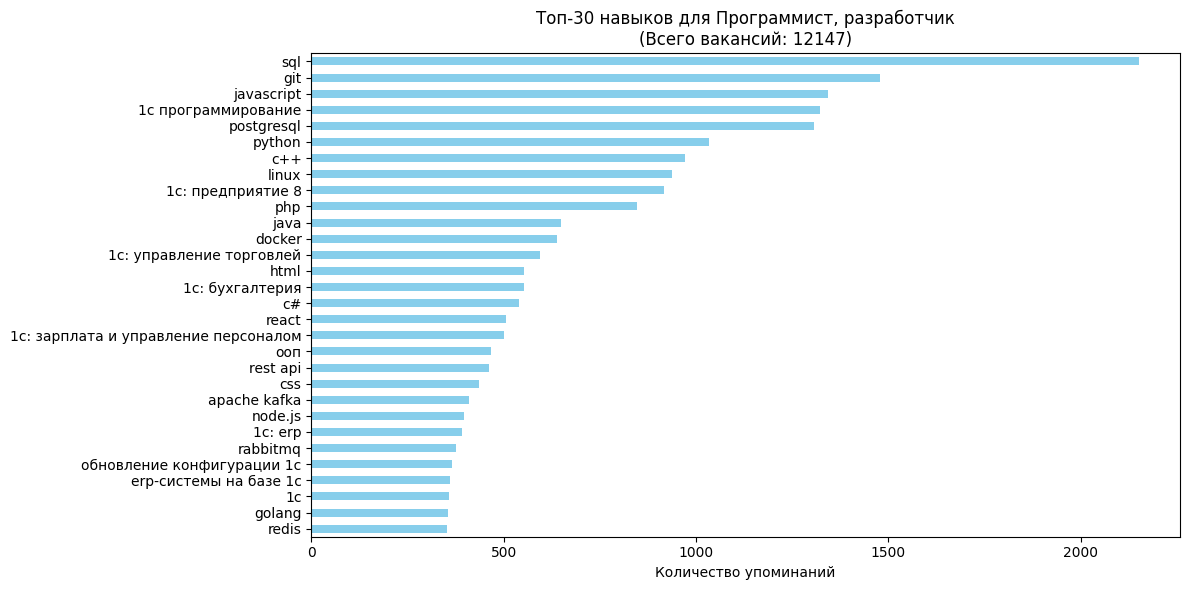

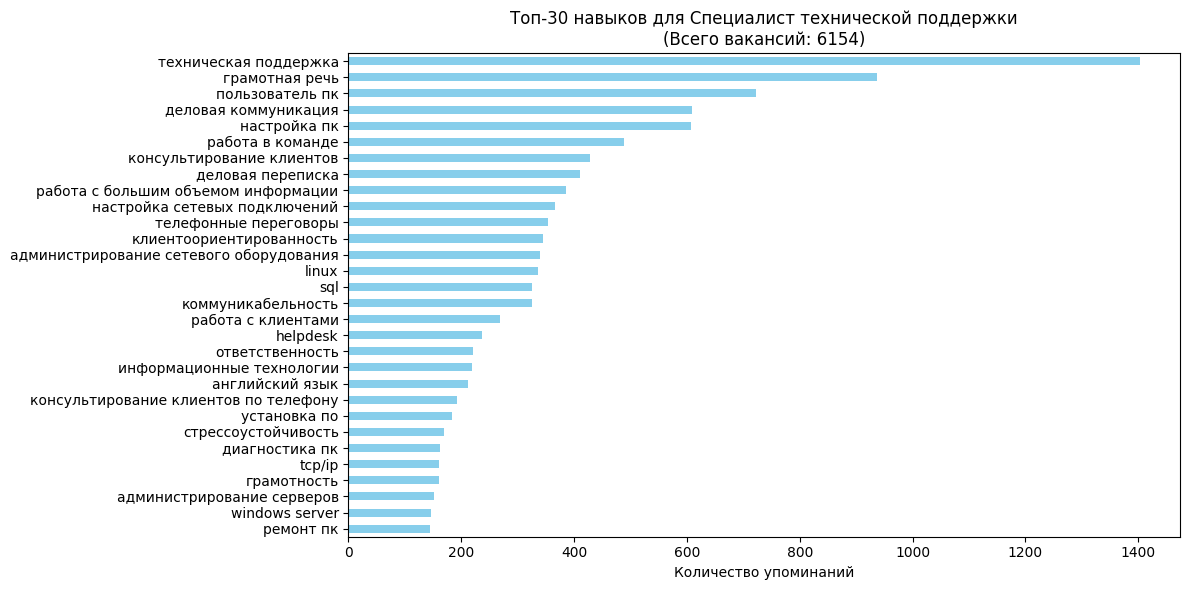

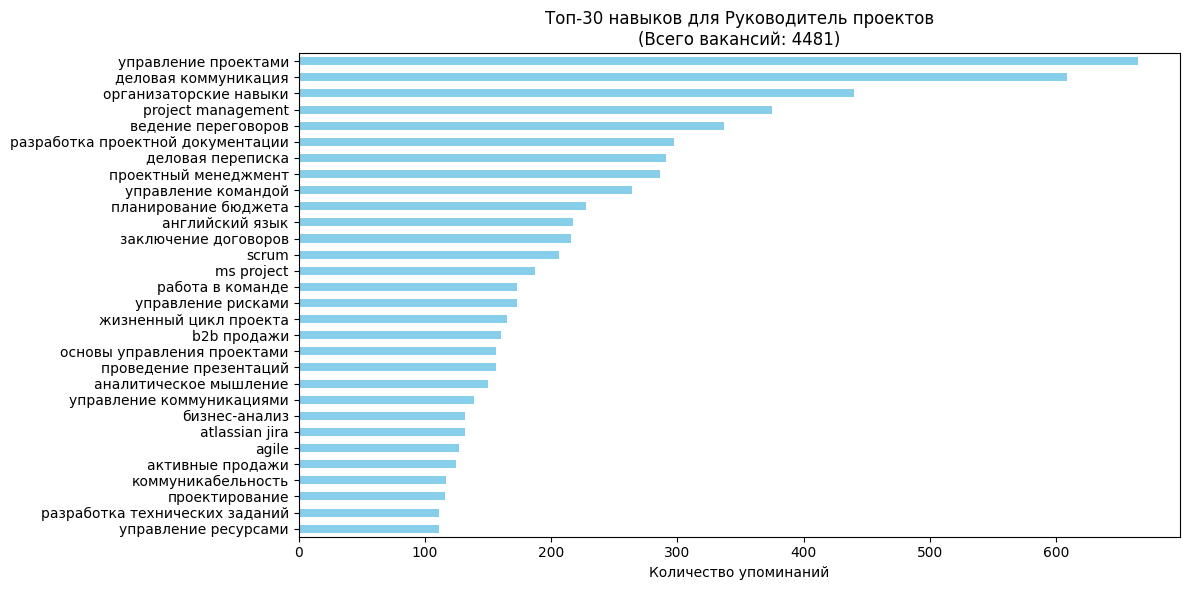

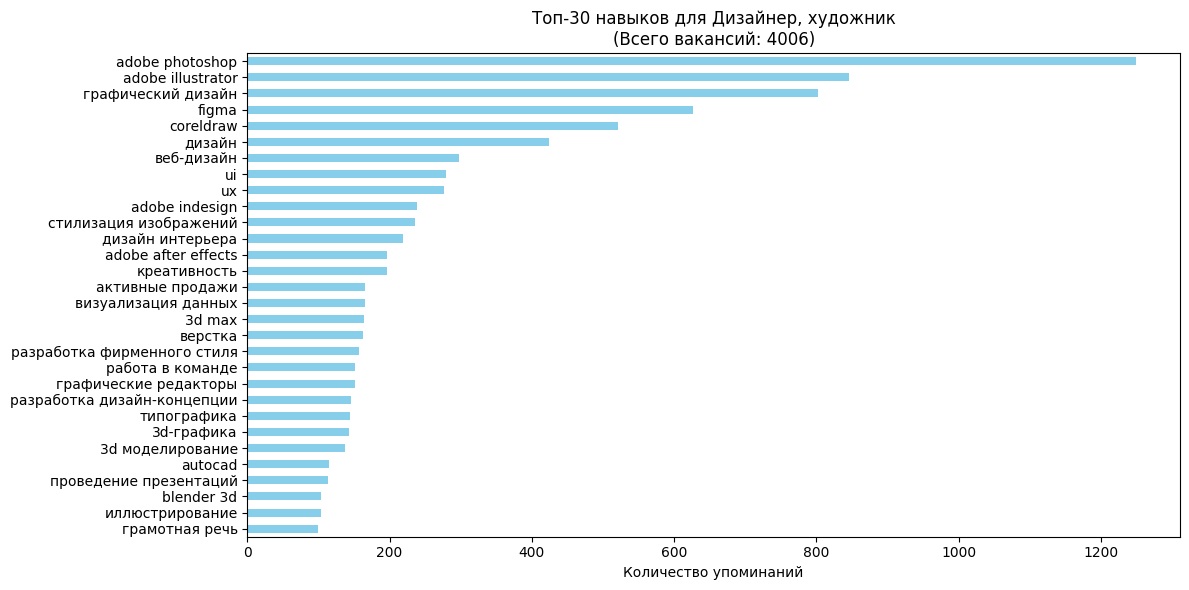

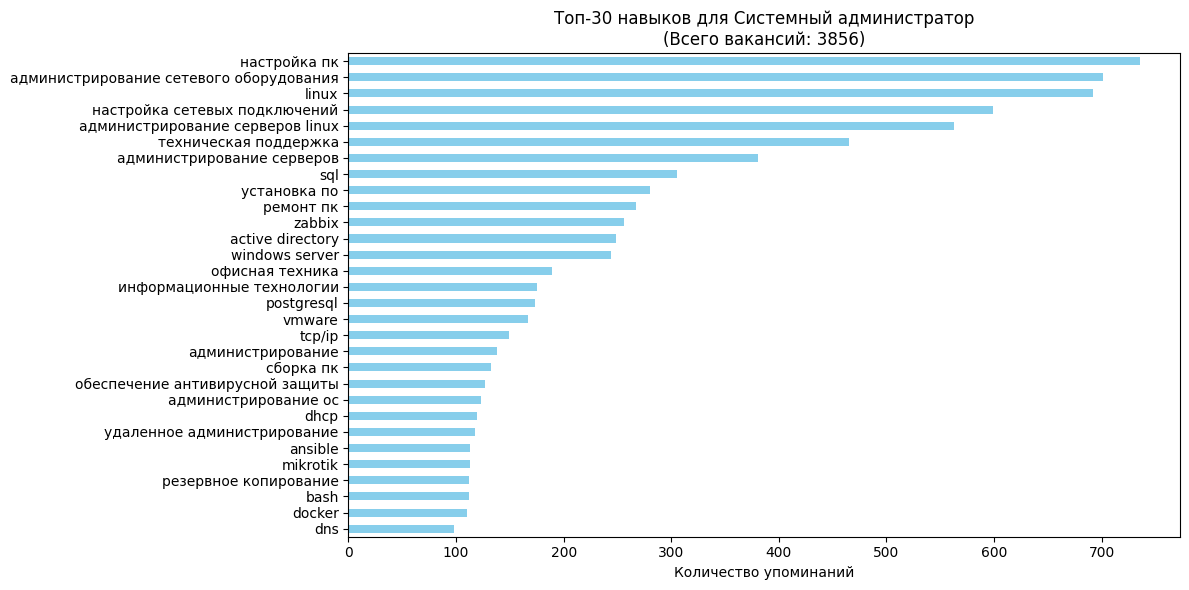

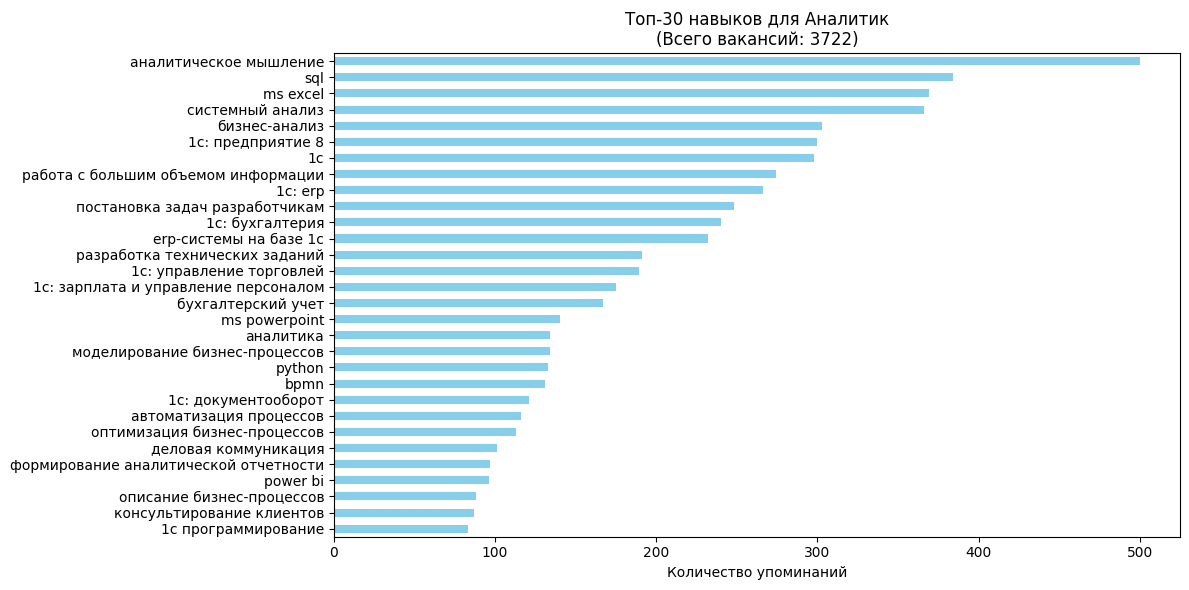

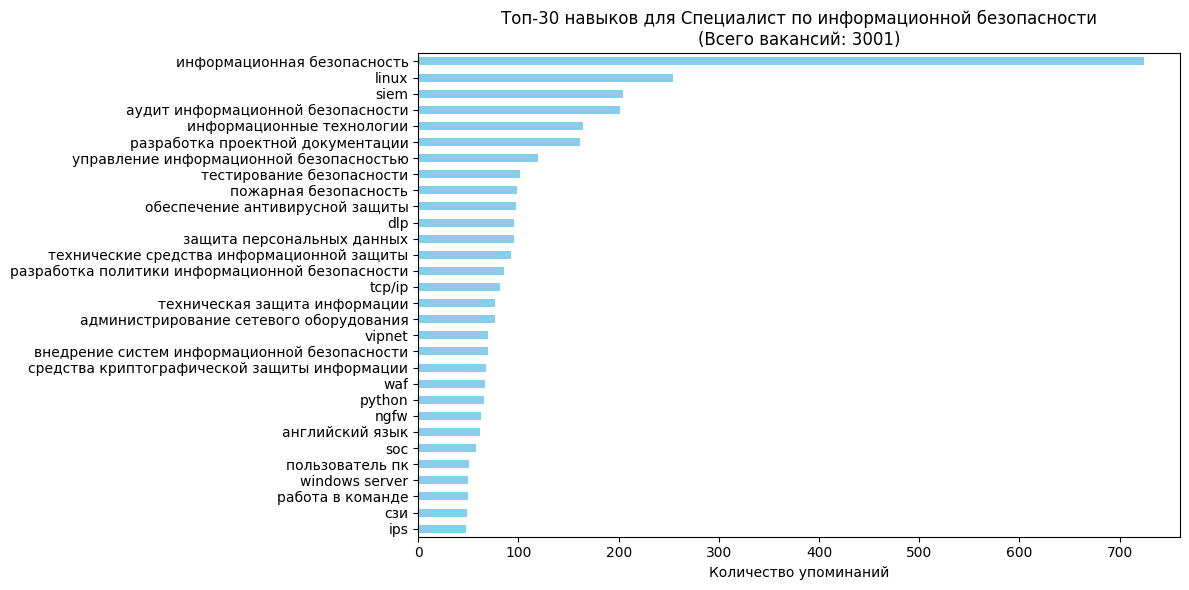

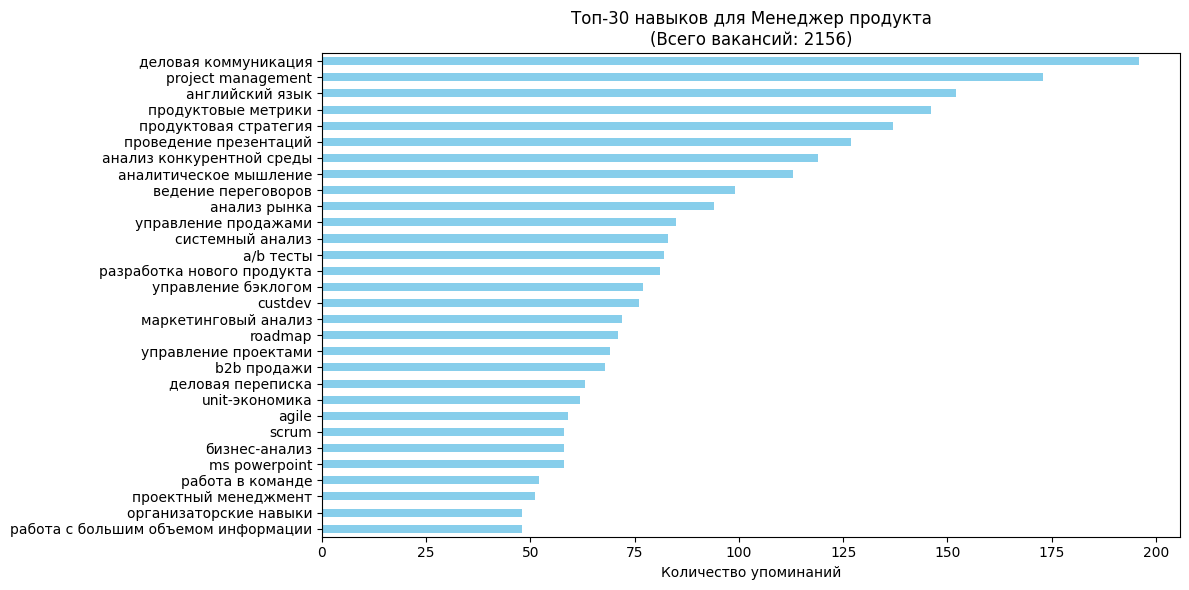

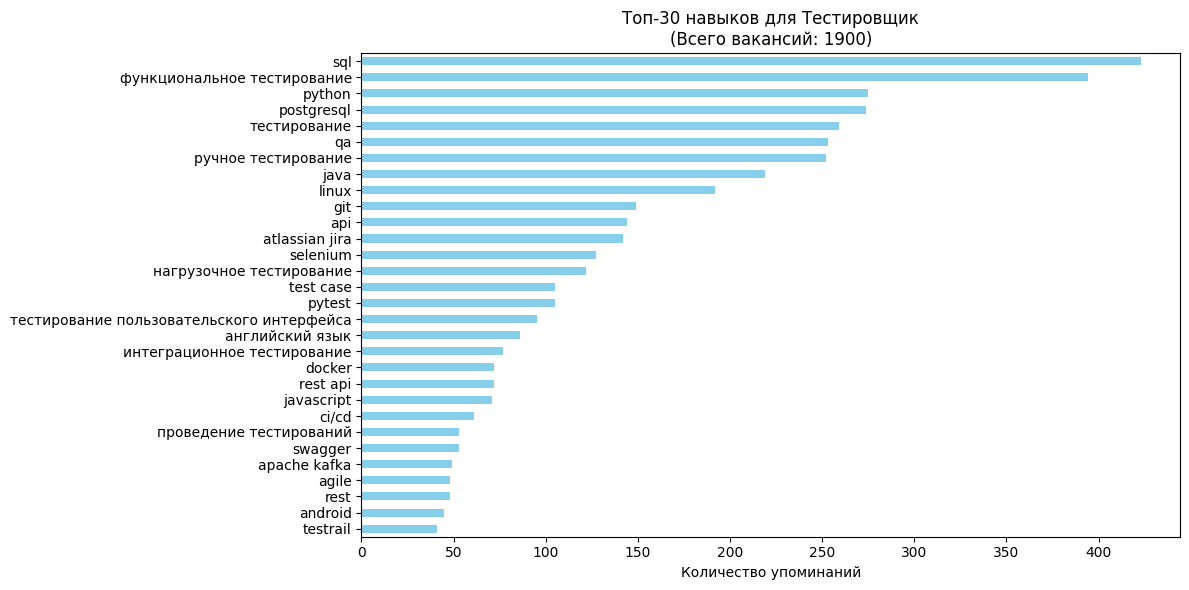

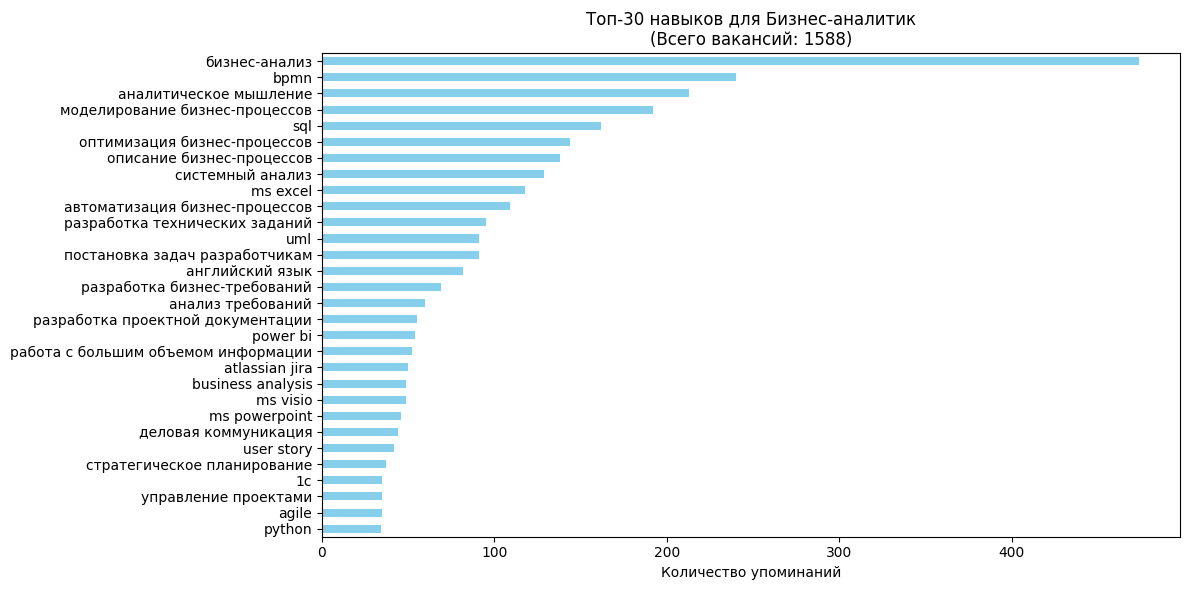

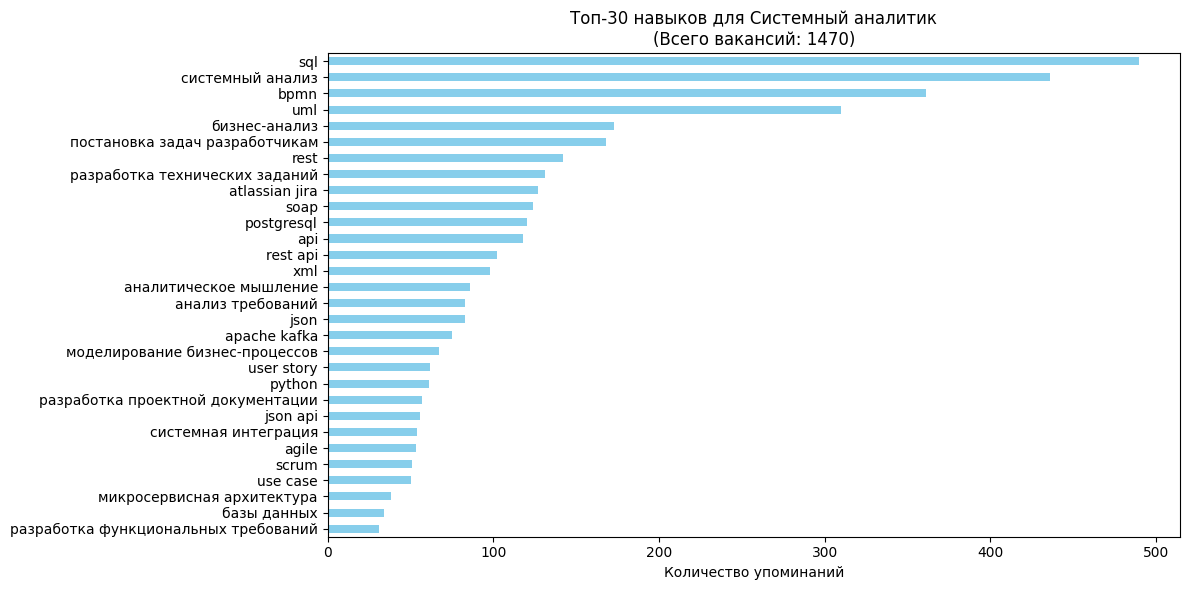

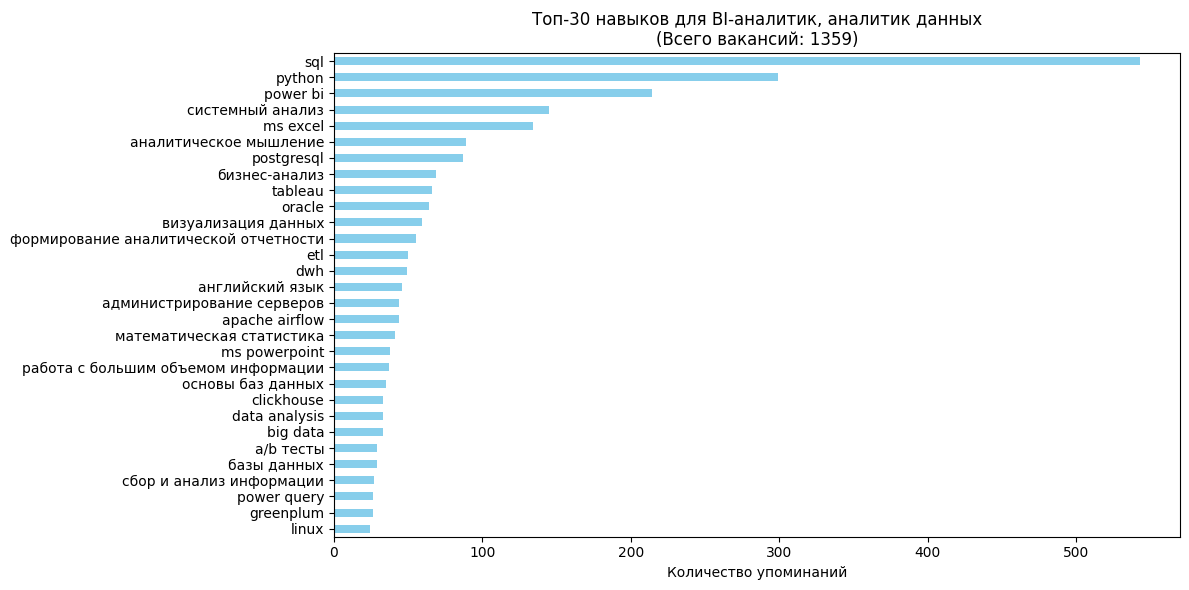

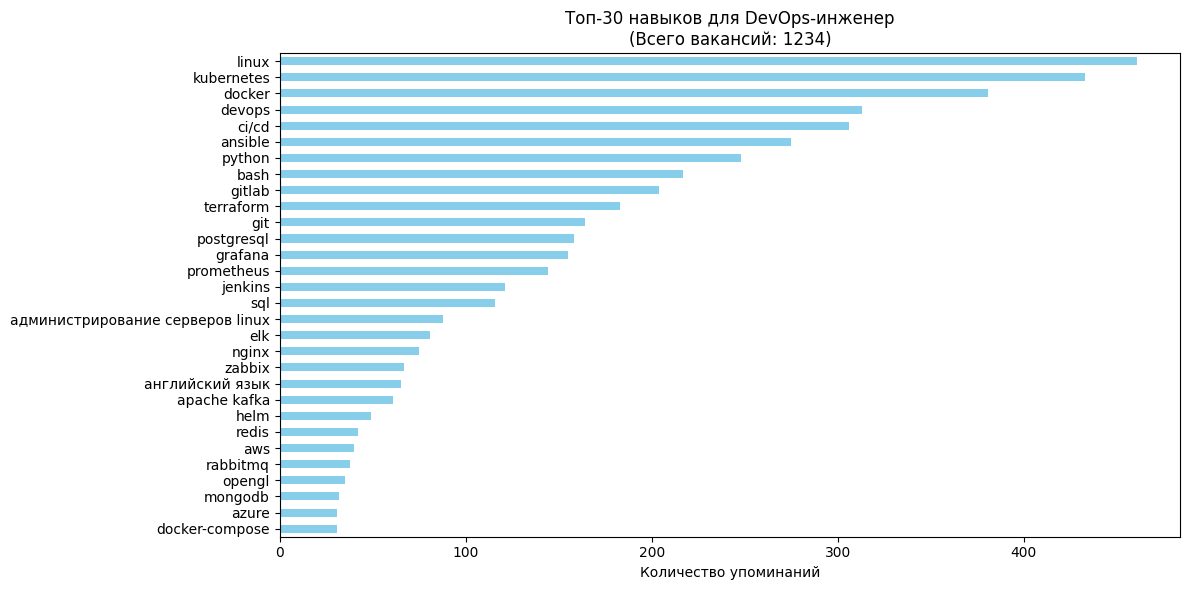

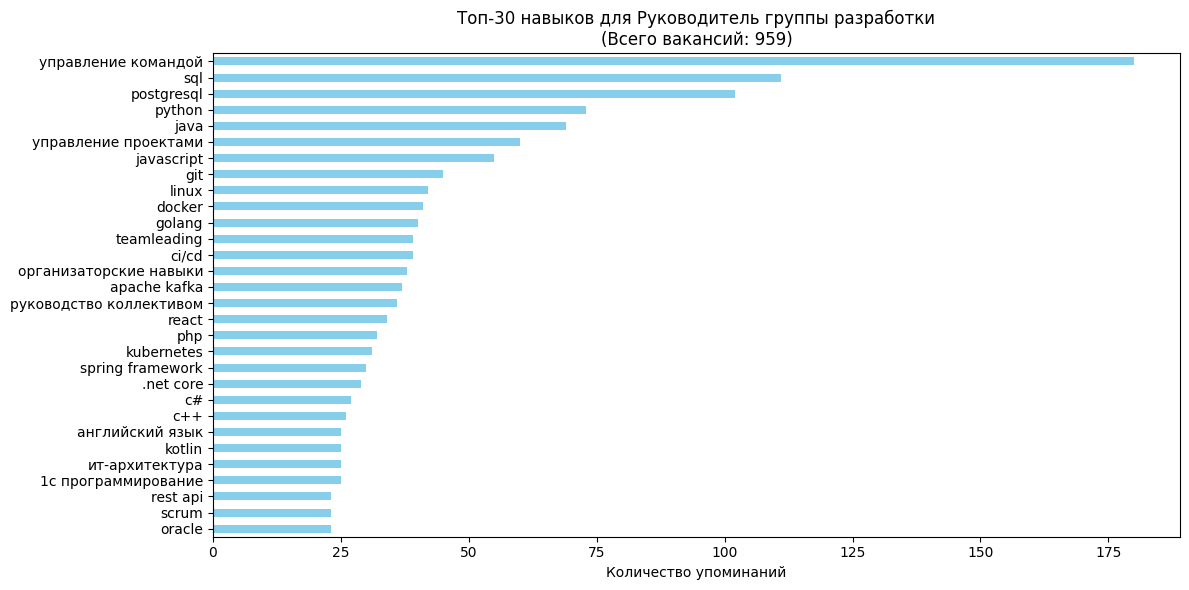

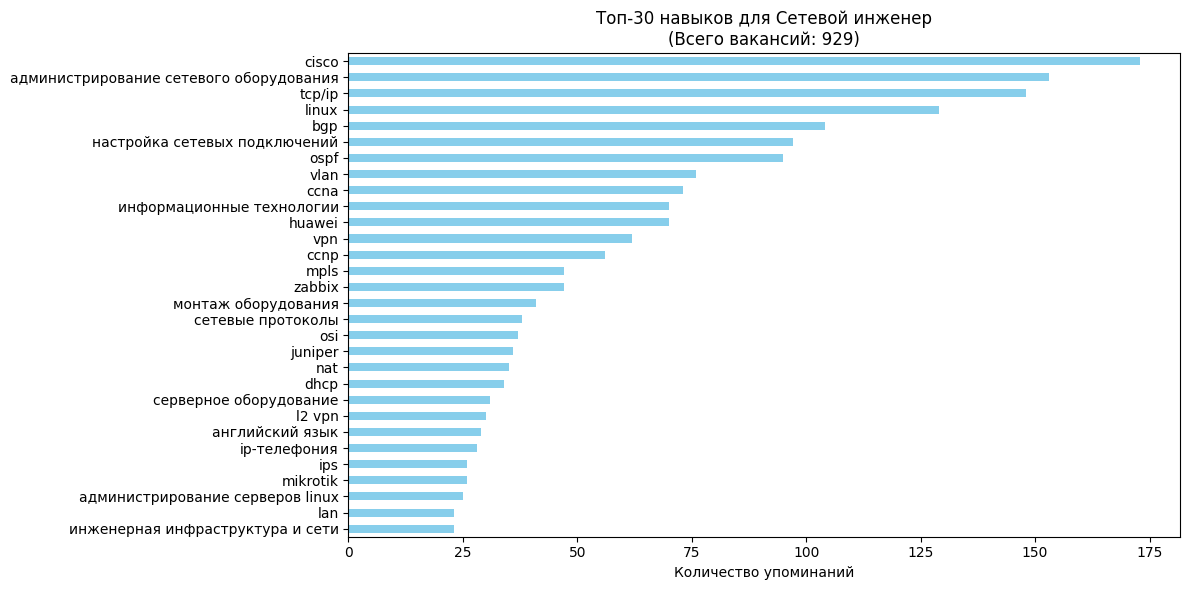

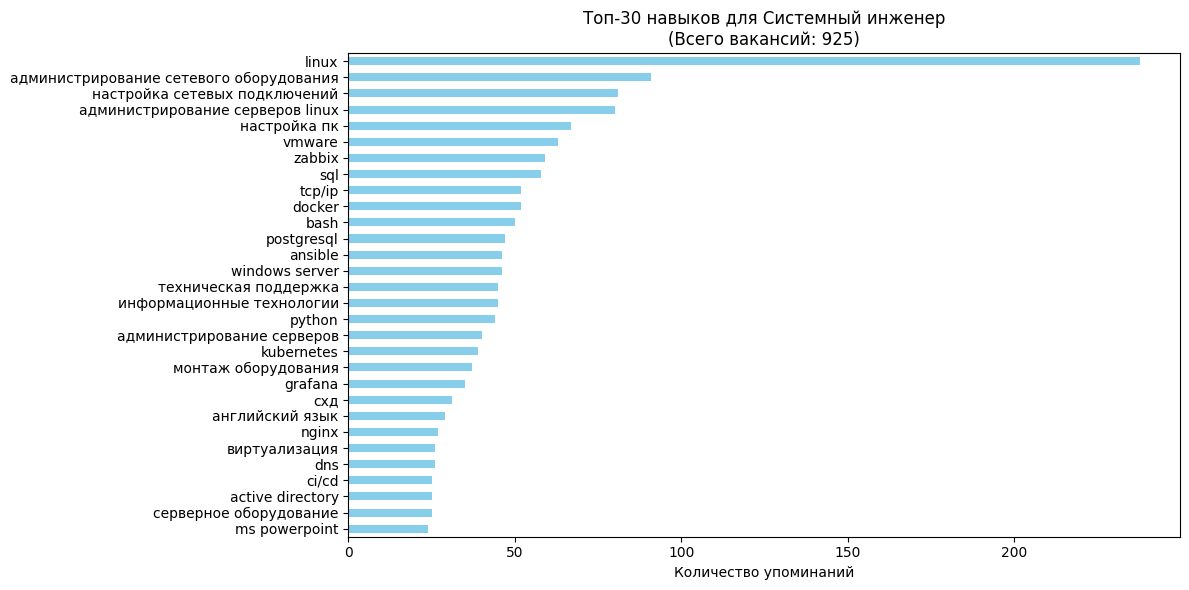

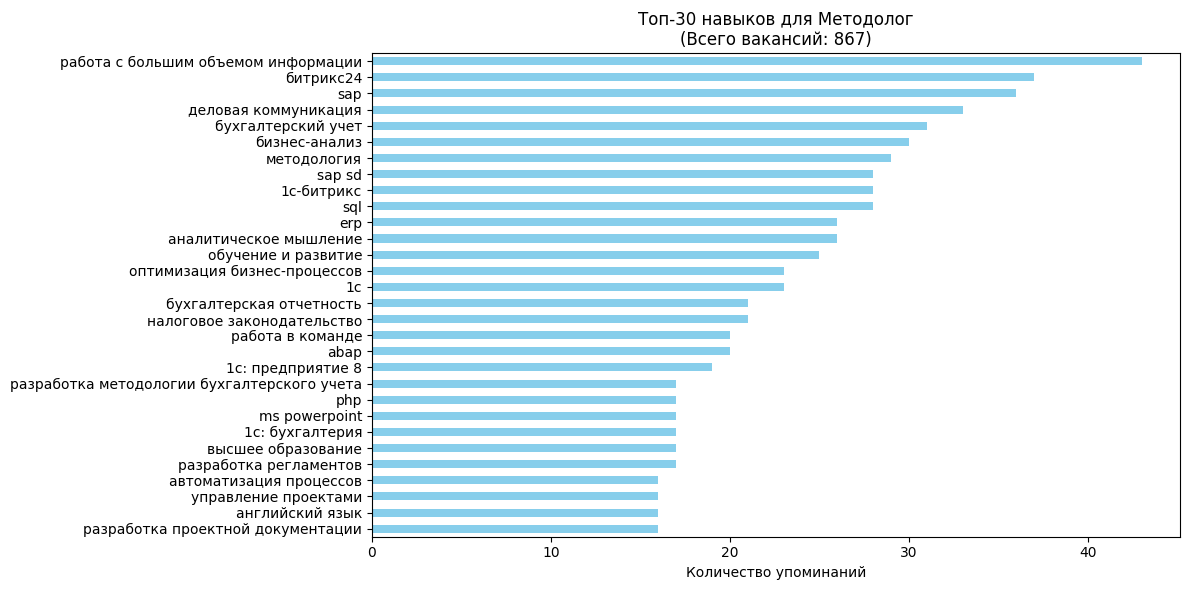

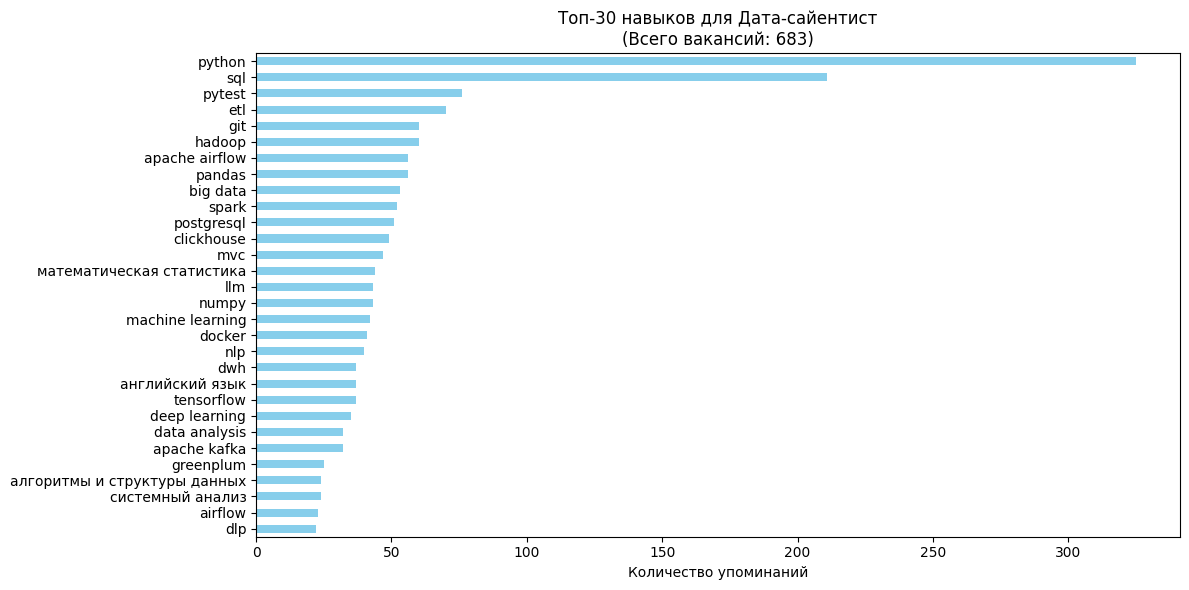

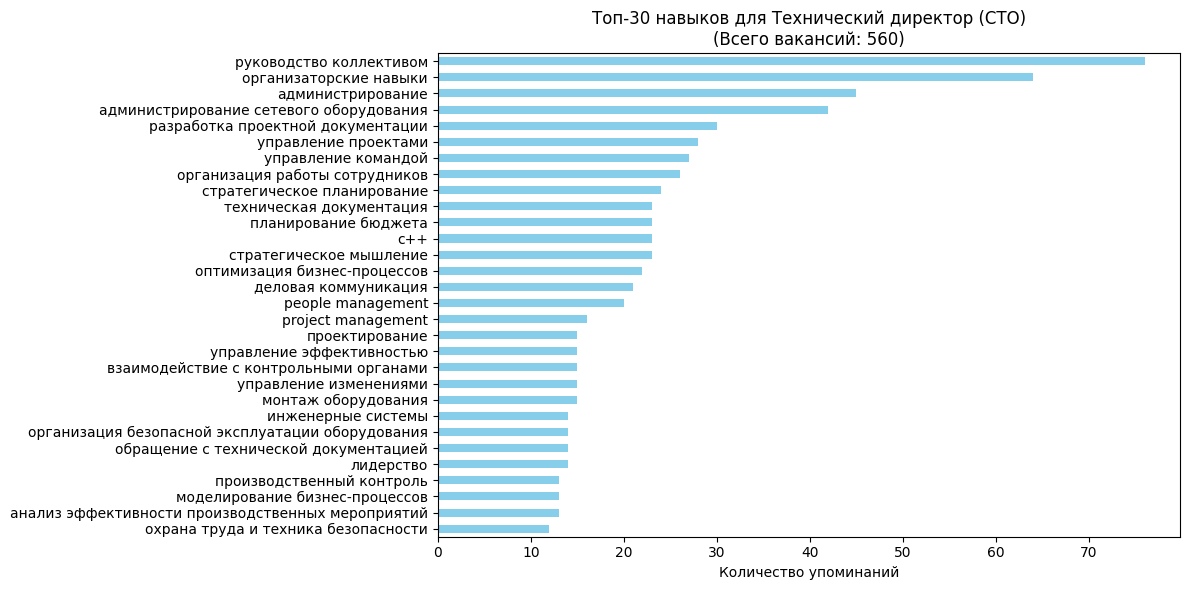

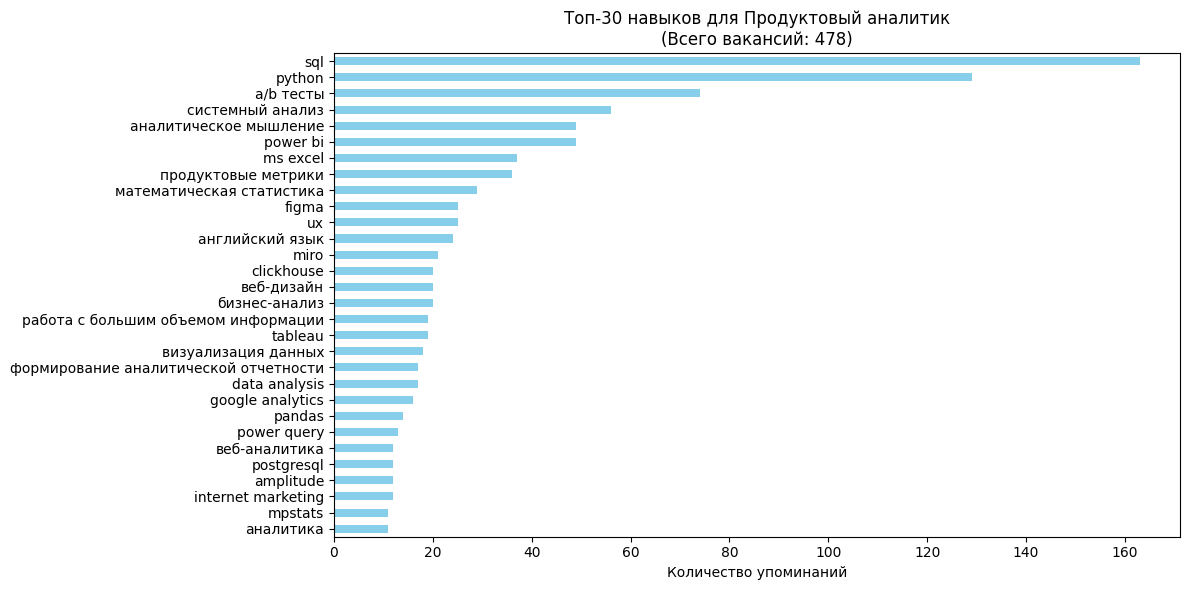

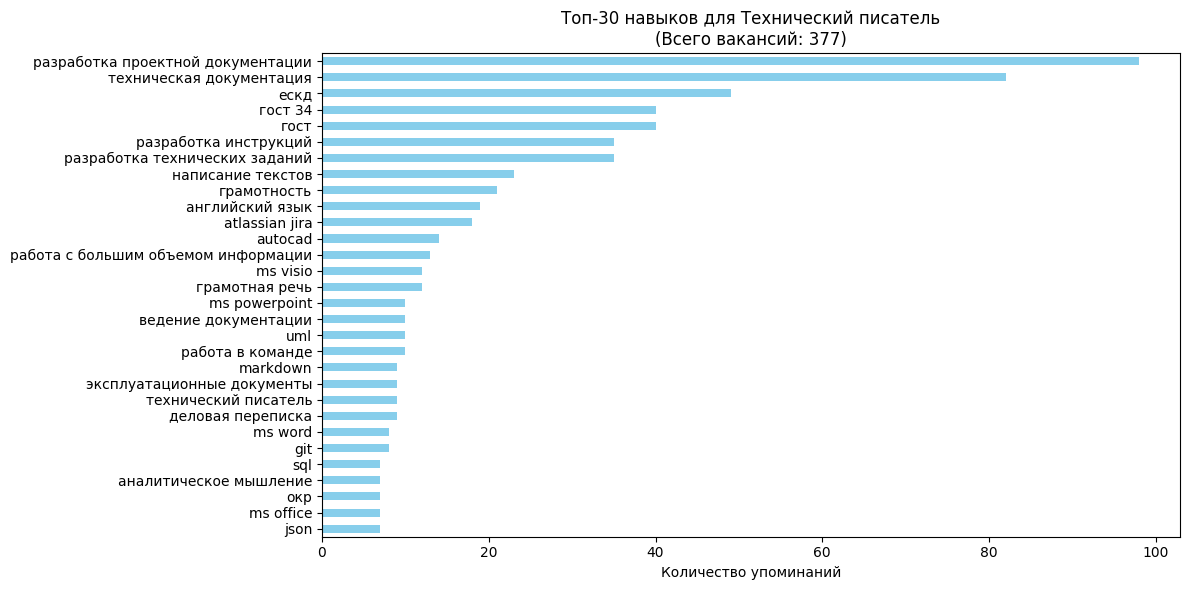

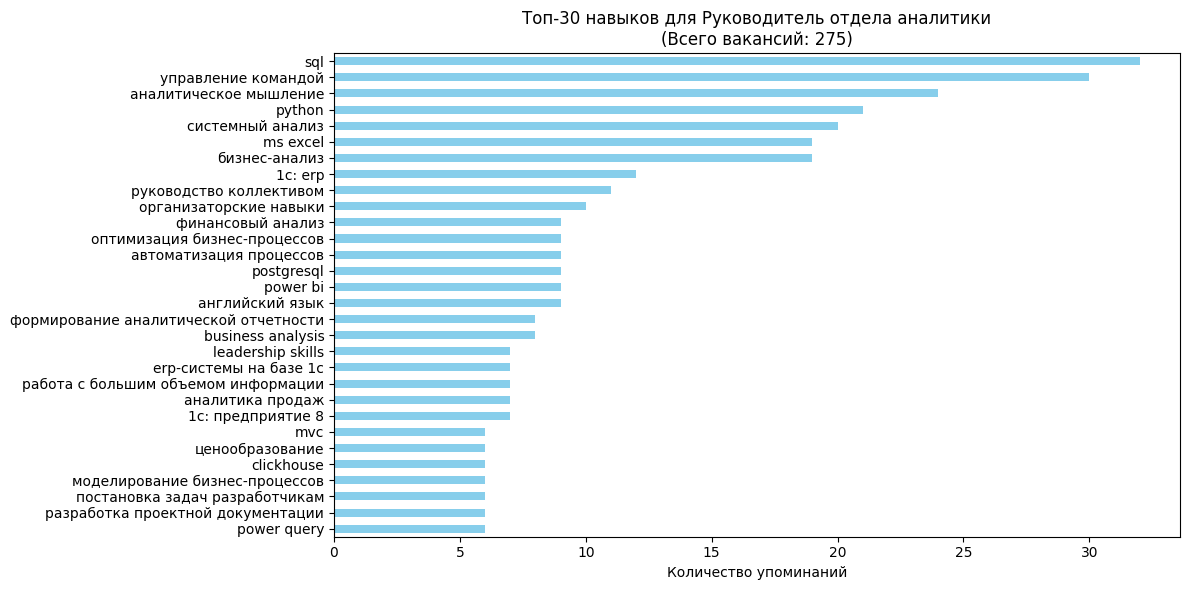

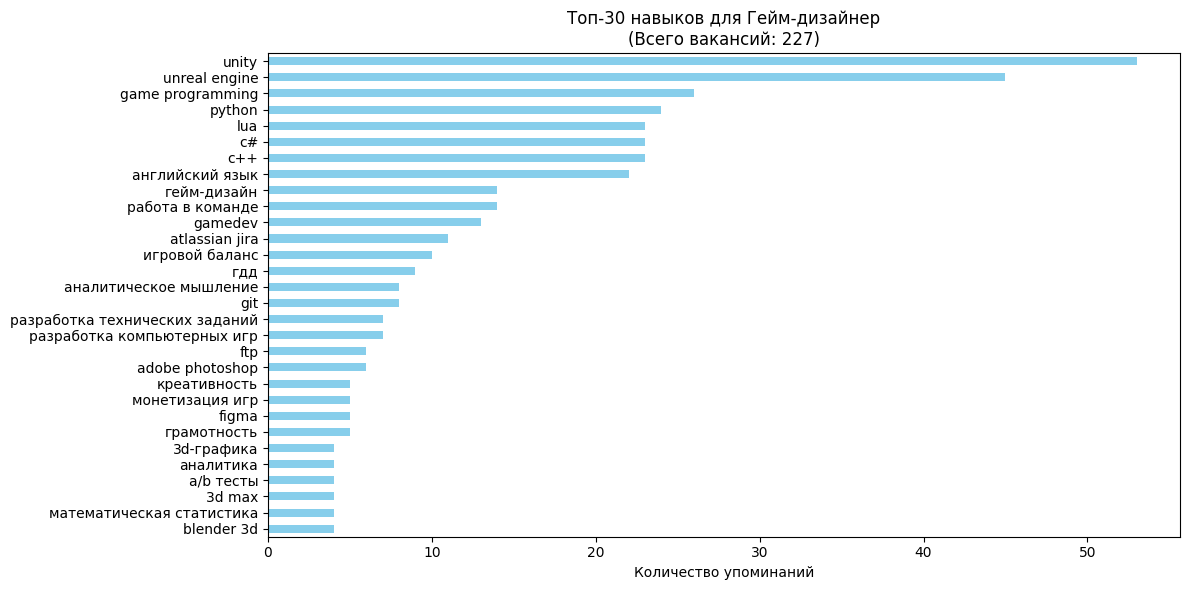

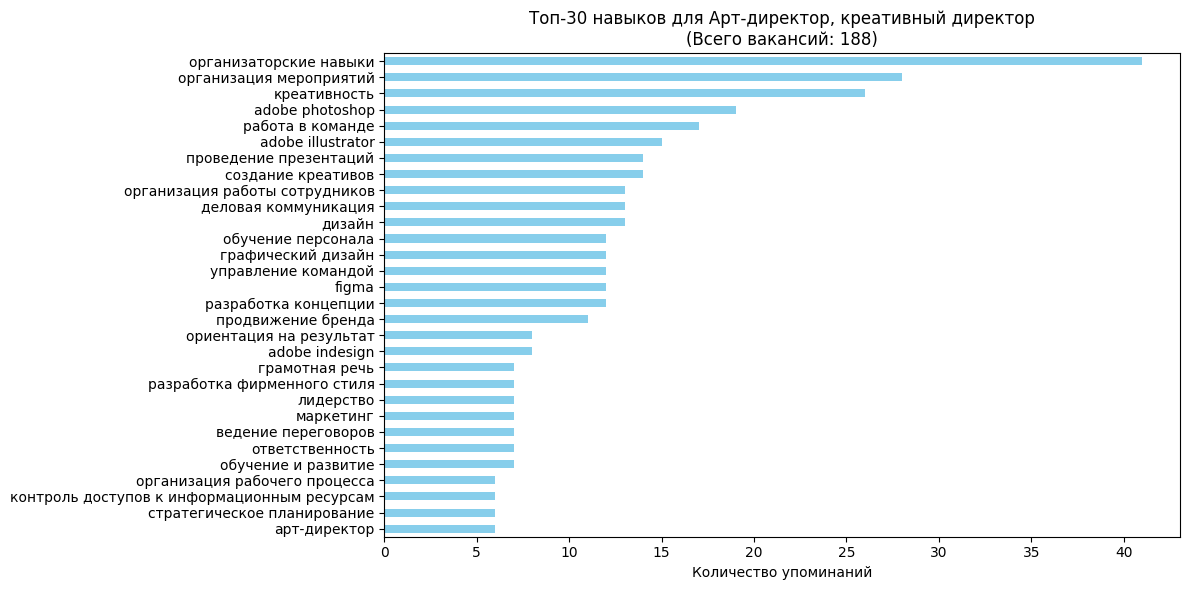

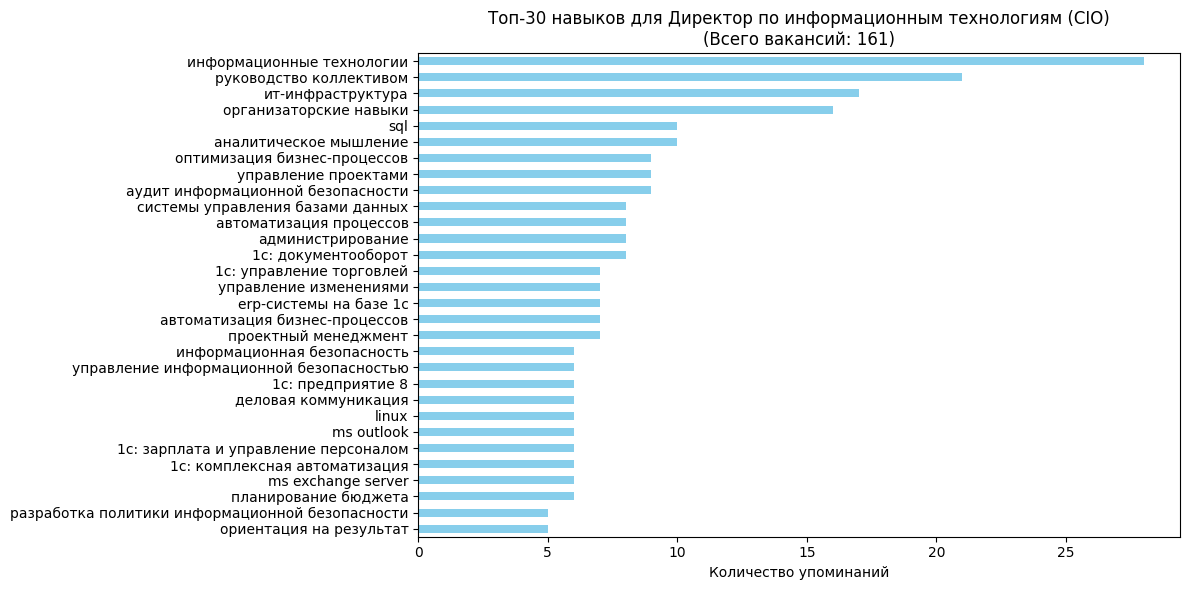

In [ ]:

positions = df['position'].value_counts().index

#–°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –∫–∞–∂–¥–æ–π –ø—Ä–æ—Ñ–µ—Å—Å–∏–∏
for position in positions:
    # –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ –ø—Ä–æ—Ñ–µ—Å—Å–∏–∏ –∏ —Å–æ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]
    
    if not skills_flat:
        continue
        
    # –°—á–∏—Ç–∞–µ–º —á–∞—Å—Ç–æ—Ç—É –Ω–∞–≤—ã–∫–æ–≤
    skills_counts = pd.Series(skills_flat).value_counts().head(30)
    
    # –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
    plt.figure(figsize=(12, 6))
    skills_counts.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'–¢–æ–ø-30 –Ω–∞–≤—ã–∫–æ–≤ –¥–ª—è {position}\n(–í—Å–µ–≥–æ –≤–∞–∫–∞–Ω—Å–∏–π: {len(df[df["position"]==position])})')
    plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π')
    plt.tight_layout()
    plt.show()

In [ ]:
# –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ —Å–∫–∏–ª–ª—ã –≤ –æ–¥–∏–Ω —Å–ø–∏—Å–æ–∫
all_skills = [skill for sublist in df["skills_clean_cl2"] for skill in sublist]
# –°—á–∏—Ç–∞–µ–º —á–∞—Å—Ç–æ—Ç—ã –≤—Å–µ—Ö —Å–∫–∏–ª–ª–æ–≤
skill_counter = Counter(all_skills)

# –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ —Ç–µ–º, —á—Ç–æ —Å–æ–¥–µ—Ä–∂–∞—Ç '1—Å' –∏–ª–∏ '1c'
filtered = {k: v for k, v in skill_counter.items() if "1—Å" in k or "1c" in k}

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ —É–±—ã–≤–∞–Ω–∏—é
filtered_sorted = dict(sorted(filtered.items(), key=lambda item: item[1], reverse=True))

# –í—ã–≤–æ–¥
print("–ù–∞–≤—ã–∫–∏, —Å–æ–¥–µ—Ä–∂–∞—â–∏–µ '1—Å' –∏–ª–∏ '1c':")
for skill, count in filtered_sorted.items():
    print(f"{skill}: {count}")

# –û–±—â–∞—è —Å—É–º–º–∞
total = sum(filtered_sorted.values())
print(f"\n–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π —Å–∫–∏–ª–ª–æ–≤ —Å '1—Å' –∏–ª–∏ '1c': {total}")

–ù–∞–≤—ã–∫–∏, —Å–æ–¥–µ—Ä–∂–∞—â–∏–µ '1—Å' –∏–ª–∏ '1c':
1—Å: –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ 8: 1563
1—Å –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ: 1546
1—Å: –±—É—Ö–≥–∞–ª—Ç–µ—Ä–∏—è: 955
1—Å: —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ç–æ—Ä–≥–æ–≤–ª–µ–π: 951
1c: erp: 818
1—Å: –∑–∞—Ä–ø–ª–∞—Ç–∞ –∏ —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω–∞–ª–æ–º: 788
erp-—Å–∏—Å—Ç–µ–º—ã –Ω–∞ –±–∞–∑–µ 1—Å: 780
1—Å: 647
1—Å: –¥–æ–∫—É–º–µ–Ω—Ç–æ–æ–±–æ—Ä–æ—Ç: 560
–æ–±–Ω–æ–≤–ª–µ–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ 1—Å: 455
1—Å-–±–∏—Ç—Ä–∏–∫—Å: 300
1—Å: –∫–æ–º–ø–ª–µ–∫—Å–Ω–∞—è –∞–≤—Ç–æ–º–∞—Ç–∏–∑–∞—Ü–∏—è: 246
1—Å: —Ç–æ—Ä–≥–æ–≤–ª—è –∏ —Å–∫–ª–∞–¥: 212
—Å–æ–∑–¥–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ 1—Å: 184
1—Å: —Ä–æ–∑–Ω–∏—Ü–∞: 123
1—Å: —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ö–æ–ª–¥–∏–Ω–≥–æ–º: 104
1c: 57
1—Å:—É—Ö: 41
1—Å: –∑—É–ø: 39
1—Å: —É—Å–Ω: 37
1—Å: —É–Ω—Ñ: 37
–∑–Ω–∞–Ω–∏–µ 1—Å: 35
1—Å 8.3: 27
–≤–Ω–µ–¥—Ä–µ–Ω–∏–µ 1—Å: 24
–ø–æ–¥–∫–ª—é—á–µ–Ω–∏–µ —Ç–æ—Ä–≥–æ–≤–æ–≥–æ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏—è –∫ 1—Å: 23
1—Å —É—Ö: 23
1—Å –±–≥—É: 21
–ø—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç 1—Å: 20
–∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∏—Ä–æ–≤–∞–Ω–∏–µ 1

In [ ]:
def replace_1c_cluster(skills):
    updated = []
    for skill in skills:
        s = skill.lower()
        if s in skills_to_merge:
            updated.append("1—Å")
        else:
            updated.append(skill)
    return list(set(updated))  # –£–±–∏—Ä–∞–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã

In [ ]:
df["skills_clean_cl2"] = df["skills_clean_cl2"].apply(replace_1c_cluster)

In [ ]:

# –û—Ç–¥–µ–ª—å–Ω–æ —Ñ–∏–ª—å—Ç—Ä—É–µ–º –ø–æ —Å–æ–¥–µ—Ä–∂–∞—â–∏–º "1—Å" (—Ä—É—Å—Å–∫–∞—è) –∏–ª–∏ "1c" (–∞–Ω–≥–ª–∏–π—Å–∫–∞—è)
skills_1c = {k: v for k, v in skill_counter.items() if "1—Å" in k or "1c" in k}

# –î–µ–ª–∏–º –ø–æ –ø–æ—Ä–æ–≥—É
skills_to_merge = {k for k, v in skills_1c.items() if v < 57}
skills_to_keep = {k: v for k, v in skills_1c.items() if v >= 57}

# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å—ë, —á—Ç–æ –Ω—É–∂–Ω–æ, –ø–æ–¥ –æ–¥–Ω–∏–º "–∫–∞–Ω–æ–Ω–æ–º"
merged_counter = {}
merged_counter["1—Å"] = sum(skill_counter[k] for k in skills_to_merge)
merged_counter.update(skills_to_keep)

# –í—ã–≤–æ–¥
for skill, count in sorted(merged_counter.items(), key=lambda x: x[1], reverse=True):
    print(f"{skill}: {count}")

print(f"\n–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π –ø–æ –≤—Å–µ–º 1—Å-–Ω–∞–≤—ã–∫–∞–º: {sum(merged_counter.values())}")

1—Å: –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ 8: 1563
1—Å –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ: 1546
1—Å: –±—É—Ö–≥–∞–ª—Ç–µ—Ä–∏—è: 955
1—Å: —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ç–æ—Ä–≥–æ–≤–ª–µ–π: 951
1c: erp: 818
1—Å: –∑–∞—Ä–ø–ª–∞—Ç–∞ –∏ —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω–∞–ª–æ–º: 788
erp-—Å–∏—Å—Ç–µ–º—ã –Ω–∞ –±–∞–∑–µ 1—Å: 780
1—Å: 647
1—Å: –¥–æ–∫—É–º–µ–Ω—Ç–æ–æ–±–æ—Ä–æ—Ç: 560
–æ–±–Ω–æ–≤–ª–µ–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ 1—Å: 455
1—Å-–±–∏—Ç—Ä–∏–∫—Å: 300
1—Å: –∫–æ–º–ø–ª–µ–∫—Å–Ω–∞—è –∞–≤—Ç–æ–º–∞—Ç–∏–∑–∞—Ü–∏—è: 246
1—Å: —Ç–æ—Ä–≥–æ–≤–ª—è –∏ —Å–∫–ª–∞–¥: 212
—Å–æ–∑–¥–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ 1—Å: 184
1—Å: —Ä–æ–∑–Ω–∏—Ü–∞: 123
1—Å: —É–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ö–æ–ª–¥–∏–Ω–≥–æ–º: 104
1c: 57

–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π –ø–æ –≤—Å–µ–º 1—Å-–Ω–∞–≤—ã–∫–∞–º: 10289


In [ ]:

# –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ç–æ–ø-80 —Å–∫–∏–ª–ª–æ–≤ –ø–æ –∫–∞–∂–¥–æ–π –ø–æ–∑–∏—Ü–∏–∏
top_skills_dict = {}

positions = df['position'].value_counts().index

for position in positions:
    # –ò–∑–≤–ª–µ–∫–∞–µ–º –Ω–∞–≤—ã–∫–∏
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]

    if not skills_flat:
        continue

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–æ–ø-80 –Ω–∞–≤—ã–∫–æ–≤
    top_80 = pd.Series(skills_flat).value_counts().head(40).index.tolist()
    top_skills_dict[position] = top_80

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Å–ª–æ–≤–∞—Ä—å –≤ DataFrame (skills –≤ —Å—Ç—Ä–æ–∫–∞—Ö, –ø–æ–∑–∏—Ü–∏–∏ ‚Äî –∫–æ–ª–æ–Ω–∫–∏)
max_len = max(len(skills) for skills in top_skills_dict.values())
df_top_skills = pd.DataFrame({
    position: skills + [None] * (max_len - len(skills))
    for position, skills in top_skills_dict.items()
})

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ Excel
df_top_skills.to_excel("top_40_skills_by_position.xlsx", index=False)

In [ ]:
all_skills = flatten_skills(df['skills_clean_cl2'])

# 3. –ü–æ–¥—Å—á–µ—Ç —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
unique_skills_count = len(set(all_skills))

In [ ]:
unique_skills_count

6255

In [ ]:


top40_share_per_position = []

for position in df['position'].unique():
    # –í—Å–µ –Ω–∞–≤—ã–∫–∏ –ø–æ –ø–æ–∑–∏—Ü–∏–∏ (–≤—Å–µ —É–ø–æ–º–∏–Ω–∞–Ω–∏—è)
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]
    
    if not skills_flat:
        continue
    
    skill_counts = Counter(skills_flat)

    total_mentions = sum(skill_counts.values())            # –≤—Å–µ–≥–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π
    total_unique_skills = len(skill_counts)                # –≤—Å–µ–≥–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –Ω–∞–≤—ã–∫–æ–≤
    
    top_40 = [skill for skill, _ in skill_counts.most_common(40)]
    top_40_mentions = sum([skill_counts[skill] for skill in top_40])
    
    share_unique = len(top_40) / total_unique_skills * 100
    share_mentions = top_40_mentions / total_mentions * 100
    
    top40_share_per_position.append({
        "position": position,
        "total_unique_skills": total_unique_skills,
        "top_40_count": len(top_40),
        "share_percent": round(share_unique, 2),             # —É–Ω–∏–∫–∞–ª—å–Ω–æ—Å—Ç—å
        "top_40_coverage_percent": round(share_mentions, 2)  # –¥–æ–ª—è –ø–æ —á–∞—Å—Ç–æ—Ç–µ
    })

df_top40_share = pd.DataFrame(top40_share_per_position)
df_top40_share = df_top40_share.sort_values(by="top_40_coverage_percent", ascending=False)

display(df_top40_share)

position  total_unique_skills  \
1                                 DevOps-–∏–Ω–∂–µ–Ω–µ—Ä                  493   
6                                 –î–∞—Ç–∞-—Å–∞–π–µ–Ω—Ç–∏—Å—Ç                  362   
5                                  –ì–µ–π–º-–¥–∏–∑–∞–π–Ω–µ—Ä                  200   
18                            –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                  642   
22                                   –¢–µ—Å—Ç–∏—Ä–æ–≤—â–∏–∫                  706   
12                          –ü—Ä–æ–¥—É–∫—Ç–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                  301   
24                          –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –ø–∏—Å–∞—Ç–µ–ª—å                  291   
0                   BI-–∞–Ω–∞–ª–∏—Ç–∏–∫, –∞–Ω–∞–ª–∏—Ç–∏–∫ –¥–∞–Ω–Ω—ã—Ö                  609   
4                                –ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏—Ç–∏–∫                  667   
17                       –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ç–æ—Ä                 1065   
7                             –î–∏–∑–∞–π–Ω–µ—Ä, —Ö—É–¥–æ–∂–Ω–∏–∫                 1065   
21              –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏                 1440   
16                               –°–µ—Ç–µ–≤–æ–π –∏–Ω–∂–µ–Ω–µ—Ä                  634   
8   –î–∏—Ä–µ–∫—Ç–æ—Ä –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–º —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è–º (CIO)                  196   
2                                       –ê–Ω–∞–ª–∏—Ç–∏–∫                 1128   
3              –ê—Ä—Ç-–¥–∏—Ä–µ–∫—Ç–æ—Ä, –∫—Ä–µ–∞—Ç–∏–≤–Ω—ã–π –¥–∏—Ä–µ–∫—Ç–æ—Ä                  280   
11                      –ü—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç, —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫                 2494   
19                             –°–∏—Å—Ç–µ–º–Ω—ã–π –∏–Ω–∂–µ–Ω–µ—Ä                  721   
23                    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –¥–∏—Ä–µ–∫—Ç–æ—Ä (CTO)                  429   
15                         –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ø—Ä–æ–µ–∫—Ç–æ–≤                 1554   
14                 –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –æ—Ç–¥–µ–ª–∞ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏                  309   
13                –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–ø–ø—ã —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏                  747   
20     –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏                 1113   
9                              –ú–µ–Ω–µ–¥–∂–µ—Ä –ø—Ä–æ–¥—É–∫—Ç–∞                 1065   
10                                     –ú–µ—Ç–æ–¥–æ–ª–æ–≥                  637   

    top_40_count  share_percent  top_40_coverage_percent  
1             40           8.11                    78.94  
6             40          11.05                    70.44  
5             40          20.00                    66.98  
18            40           6.23                    65.65  
22            40           5.67                    65.06  
12            40          13.29                    64.15  
24            40          13.75                    64.03  
0             40           6.57                    63.68  
4             40           6.00                    62.61  
17            40           3.76                    60.53  
7             40           3.76                    60.26  
21            40           2.78                    59.76  
16            40           6.31                    57.33  
8             40          20.41                    55.54  
2             40           3.55                    55.26  
3             40          14.29                    52.46  
11            40           1.60                    50.76  
19            40           5.55                    49.57  
23            40           9.32                    49.28  
15            40           2.57                    48.59  
14            40          12.94                    47.03  
13            40           5.35                    46.06  
20            40           3.59                    45.63  
9             40           3.76                    45.30  
10            40           6.28                    39.24

In [ ]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã
TOP_N = 100

# –•—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
stats = []


for position in positions:
    # –ò–∑–≤–ª–µ–∫–∞–µ–º –≤—Å–µ –Ω–∞–≤—ã–∫–∏ –ø–æ –ø–æ–∑–∏—Ü–∏–∏
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]

    if not skills_flat:
        continue

    # –ü–æ–¥—Å—á—ë—Ç—ã
    total_count = len(skills_flat)  # –æ–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–≤—ã–∫–æ–≤ (–≤–∫–ª—é—á–∞—è –ø–æ–≤—Ç–æ—Ä—ã)
    total_unique_skills = len(set(skills_flat))  # —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –Ω–∞–≤—ã–∫–∏

    skills_series = pd.Series(skills_flat)
    top_skills = skills_series.value_counts().head(TOP_N)

    top_n_coverage = top_skills.sum()  # —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ top-N –Ω–∞–≤—ã–∫–∏ —É–ø–æ–º–∏–Ω–∞—é—Ç—Å—è
    unique_top_skills = len(top_skills)

    top_n_coverage_percent = round(top_n_coverage / total_count * 100, 2)
    share_percent = round(unique_top_skills / total_unique_skills * 100, 2)

    stats.append({
        'position': position,
        'total_unique_skills': total_unique_skills,
        'unique_top_skills': unique_top_skills,
        #'top_n_coverage': top_n_coverage,
        #'total_count': total_count,
        'top_100_coverage_percent': top_n_coverage_percent,
        
        
        'share_percent': share_percent
    })

# –í DataFrame
df_stats = pd.DataFrame(stats)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º
output_path = "top100_skills_stats_by_position.xlsx"
df_stats.to_excel(output_path, index=False)

In [ ]:
display(df_stats)

position  total_unique_skills  \
0                       –ü—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç, —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫                 2494   
1               –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏                 1440   
2                          –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ø—Ä–æ–µ–∫—Ç–æ–≤                 1554   
3                             –î–∏–∑–∞–π–Ω–µ—Ä, —Ö—É–¥–æ–∂–Ω–∏–∫                 1065   
4                        –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ç–æ—Ä                 1065   
5                                       –ê–Ω–∞–ª–∏—Ç–∏–∫                 1128   
6      –°–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω–æ–π –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏                 1113   
7                              –ú–µ–Ω–µ–¥–∂–µ—Ä –ø—Ä–æ–¥—É–∫—Ç–∞                 1065   
8                                    –¢–µ—Å—Ç–∏—Ä–æ–≤—â–∏–∫                  706   
9                                –ë–∏–∑–Ω–µ—Å-–∞–Ω–∞–ª–∏—Ç–∏–∫                  667   
10                            –°–∏—Å—Ç–µ–º–Ω—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                  642   
11                  BI-–∞–Ω–∞–ª–∏—Ç–∏–∫, –∞–Ω–∞–ª–∏—Ç–∏–∫ –¥–∞–Ω–Ω—ã—Ö                  609   
12                                DevOps-–∏–Ω–∂–µ–Ω–µ—Ä                  493   
13                –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–ø–ø—ã —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏                  747   
14                               –°–µ—Ç–µ–≤–æ–π –∏–Ω–∂–µ–Ω–µ—Ä                  634   
15                             –°–∏—Å—Ç–µ–º–Ω—ã–π –∏–Ω–∂–µ–Ω–µ—Ä                  721   
16                                     –ú–µ—Ç–æ–¥–æ–ª–æ–≥                  637   
17                                –î–∞—Ç–∞-—Å–∞–π–µ–Ω—Ç–∏—Å—Ç                  362   
18                    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –¥–∏—Ä–µ–∫—Ç–æ—Ä (CTO)                  429   
19                          –ü—Ä–æ–¥—É–∫—Ç–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫                  301   
20                          –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –ø–∏—Å–∞—Ç–µ–ª—å                  291   
21                 –†—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –æ—Ç–¥–µ–ª–∞ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏                  309   
22                                 –ì–µ–π–º-–¥–∏–∑–∞–π–Ω–µ—Ä                  200   
23             –ê—Ä—Ç-–¥–∏—Ä–µ–∫—Ç–æ—Ä, –∫—Ä–µ–∞—Ç–∏–≤–Ω—ã–π –¥–∏—Ä–µ–∫—Ç–æ—Ä                  280   
24  –î–∏—Ä–µ–∫—Ç–æ—Ä –ø–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–º —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è–º (CIO)                  196   

    unique_top_skills  top_100_coverage_percent  share_percent  
0                 100                     68.78           4.01  
1                 100                     75.40           6.94  
2                 100                     68.19           6.44  
3                 100                     78.53           9.39  
4                 100                     78.05           9.39  
5                 100                     72.97           8.87  
6                 100                     65.59           8.98  
7                 100                     66.31           9.39  
8                 100                     81.55          14.16  
9                 100                     77.81          14.99  
10                100                     81.66          15.58  
11                100                     76.87          16.42  
12                100                     89.71          20.28  
13                100                     65.65          13.39  
14                100                     73.34          15.77  
15                100                     67.24          13.87  
16                100                     60.81          15.70  
17                100                     86.89          27.62  
18                100                     69.90          23.31  
19                100                     83.03          33.22  
20                100                     79.48          34.36  
21                100                     70.07          32.36  
22                100                     84.50          50.00  
23                100                     75.49          35.71  
24                100            